# Analytics - Product Quality

#### Date: 2023/12

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: PrintGo

##### Semester: 2023/02
##### Professor: Hilmer Neri

##### Members:

- Member x
- Member y


### LIBRARIES

In [554]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [555]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [556]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [557]:
# Set your repo major name here
# Example: fga-eps-mds-2022-1-MeasureSoftGram-
repo_name = 'fga-eps-mds-2023.2-PrintGo-'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'FrontEnd': 'js',
    'UserService': 'ts',
    'PrinterService': 'ts',
}

### SonarCloud
##### Path to the folder with all your jsons

In [558]:
# Maybe you should change this path to your own path

sonar_files = glob('./analytics-raw-data/*.json')

## Create DataFrame

#### Unmarshall json

In [559]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [560]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [561]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [562]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [563]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [564]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[5]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)


    df['repository'] = aux_df[0]
    print(df['repository'])
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]


    df = df.sort_values(by=['repository', 'datetime'])
    
    return df

In [565]:
file_component_df = create_component_df(sonar_files)
file_component_df.repository.unique()


0         fga-eps-mds-2023.2-PrintGo-UserService
1         fga-eps-mds-2023.2-PrintGo-UserService
2         fga-eps-mds-2023.2-PrintGo-UserService
3         fga-eps-mds-2023.2-PrintGo-UserService
4         fga-eps-mds-2023.2-PrintGo-UserService
5         fga-eps-mds-2023.2-PrintGo-UserService
6         fga-eps-mds-2023.2-PrintGo-UserService
7         fga-eps-mds-2023.2-PrintGo-UserService
8         fga-eps-mds-2023.2-PrintGo-UserService
9         fga-eps-mds-2023.2-PrintGo-UserService
10        fga-eps-mds-2023.2-PrintGo-UserService
11        fga-eps-mds-2023.2-PrintGo-UserService
12        fga-eps-mds-2023.2-PrintGo-UserService
13        fga-eps-mds-2023.2-PrintGo-UserService
14        fga-eps-mds-2023.2-PrintGo-UserService
15        fga-eps-mds-2023.2-PrintGo-UserService
16        fga-eps-mds-2023.2-PrintGo-UserService
17        fga-eps-mds-2023.2-PrintGo-UserService
18        fga-eps-mds-2023.2-PrintGo-UserService
19        fga-eps-mds-2023.2-PrintGo-UserService
20        fga-eps-md

array(['fga-eps-mds-2023.2-PrintGo-FrontEnd',
       'fga-eps-mds-2023.2-PrintGo-PrinterService',
       'fga-eps-mds-2023.2-PrintGo-UserService'], dtype=object)

### Create dataframe per repository

In [566]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    print(repo_name)
    print(file_component_df['repository'].keys)
    repos_dataframes.append({'name': repo, 'df': dataframe})

fga-eps-mds-2023.2-PrintGo-
<bound method Series.keys of 605          fga-eps-mds-2023.2-PrintGo-FrontEnd
606          fga-eps-mds-2023.2-PrintGo-FrontEnd
607          fga-eps-mds-2023.2-PrintGo-FrontEnd
608          fga-eps-mds-2023.2-PrintGo-FrontEnd
609          fga-eps-mds-2023.2-PrintGo-FrontEnd
610          fga-eps-mds-2023.2-PrintGo-FrontEnd
611          fga-eps-mds-2023.2-PrintGo-FrontEnd
612          fga-eps-mds-2023.2-PrintGo-FrontEnd
613          fga-eps-mds-2023.2-PrintGo-FrontEnd
614          fga-eps-mds-2023.2-PrintGo-FrontEnd
615          fga-eps-mds-2023.2-PrintGo-FrontEnd
616          fga-eps-mds-2023.2-PrintGo-FrontEnd
617          fga-eps-mds-2023.2-PrintGo-FrontEnd
425          fga-eps-mds-2023.2-PrintGo-FrontEnd
426          fga-eps-mds-2023.2-PrintGo-FrontEnd
427          fga-eps-mds-2023.2-PrintGo-FrontEnd
428          fga-eps-mds-2023.2-PrintGo-FrontEnd
429          fga-eps-mds-2023.2-PrintGo-FrontEnd
430          fga-eps-mds-2023.2-PrintGo-FrontEnd
431         

## Measure calculations according to Q-Rapids quality model

In [567]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
            print(n)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [568]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [569]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [570]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [571]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [572]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [573]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [574]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    print(date_time_vec)

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)
        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }


    metrics_df = pd.DataFrame(final_dict)
    
    return metrics_df

In [575]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    print(repo_df)
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

{'name': 'FrontEnd', 'df':                                                  path functions complexity  \
605                                        src/App.js         1          1   
606                                   src/App.test.js         1          1   
607                                 src/pages/Home.js         1          1   
608                                      src/index.js         0          0   
609                          src/components/Navbar.js         0          0   
610                            src/reportWebVitals.js         2          4   
611                                 src/setupTests.js         0          0   
612                                    src/components         0          0   
613                              src/style/components       NaN        NaN   
614                                         src/pages         1          1   
615                                   src/style/pages       NaN        NaN   
616                                  

/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with 

38
21
7
23
73
70
41
12
12
84
34
12
1
38
35
39
302
436
955
475
38
21
7
23
73
72
41
12
12
89
24
12
1
38
35
42
299
488
1007
530
38
23
7
23
73
8
72
12
41
12
12
89
17
27
12
1
150
9
38
185
182
150
8
314
520
26
1380
702
0
38
23
7
23
72
8
72
12
41
12
20
89
17
27
12
1
150
9
38
193
182
150
8
313
510
26
1377
692
0
43
23
7
23
72
8
72
12
41
12
20
89
17
27
12
1
150
9
43
193
182
150
8
313
510
26
1382
692
0
77
23
7
23
72
8
72
12
41
12
20
89
17
27
12
1
149
9
77
192
182
149
8
313
510
26
1415
692
0
77
23
23
72
8
72
12
41
12
20
89
17
27
12
1
149
9
77
192
182
149
8
313
510
26
1408
692
0
77
23
23
72
8
72
12
41
12
20
89
17
27
12
1
149
9
77
192
182
149
8
313
510
26
1408
692
0
77
23
23
72
8
72
12
41
12
20
89
17
27
12
1
149
9
77
192
182
149
8
313
510
26
1408
692
0


/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()


77
23
23
72
8
72
12
41
12
20
89
17
27
12
1
149
9
77
192
182
149
8
313
510
26
1408
692
0
45
77
23
23
105
8
89
16
38
12
20
104
17
57
32
12
1
149
9
77
281
400
149
8
89
397
508
26
1797
908
0
45
31
33
23
105
8
75
16
16
150
16
84
38
12
20
103
66
57
32
16
93
180
16
76
12
1
192
9
9
62
31
855
1089
595
8
89
626
724
18
3461
1813
66
62
{'name': 'UserService', 'df':                                                  path functions complexity  \
438                                      app/index.ts         2          3   
439                                               app         2          3   
520                                      app/index.ts         2          3   
521                                               app         2          3   
715                    src/adapters/bcrypt.adapter.ts         1          1   
716                     src/types/enum/Cargos.enum.ts         0          0   
717      src/middlewares/checkCpfOrCnpj.middleware.ts         3         13   
718                 

/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with 

4
4
79
5
74
8
21
3
7
15
180
11
27
4
254
5
4
86
19
438
55
4
4
79
5
74
8
21
3
7
15
180
11
27
4
254
5
4
86
19
438
55
4
4
79
5
74
8
21
3
7
15
180
11
27
4
254
5
4
86
19
438
55
4
4
79
3
3
7
30
13
170
11
27
4
170
3
4
86
11
30
351
34
4
4
79
3
3
7
30
13
171
11
27
4
171
3
4
86
11
30
352
34
{'name': 'PrinterService', 'df':                                                  path functions complexity  \
549                                     src/server.ts         2          2   
550                                               src         2          2   
618                                     src/server.ts         2          2   
619                                               src         2          2   
55                 src/middlewares/errorMiddleware.ts         1          1   
56           src/controllers/Impressora.controller.ts         4          8   
57                       src/types/Impressora.type.ts         0          0   
58                              src/database/index.ts         

/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()
/tmp/ipykernel_26880/2067229751.py:6: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_value_index = newdf.idxmax()


## Data visualization

In this area you will need to plot the metrics of each repository.

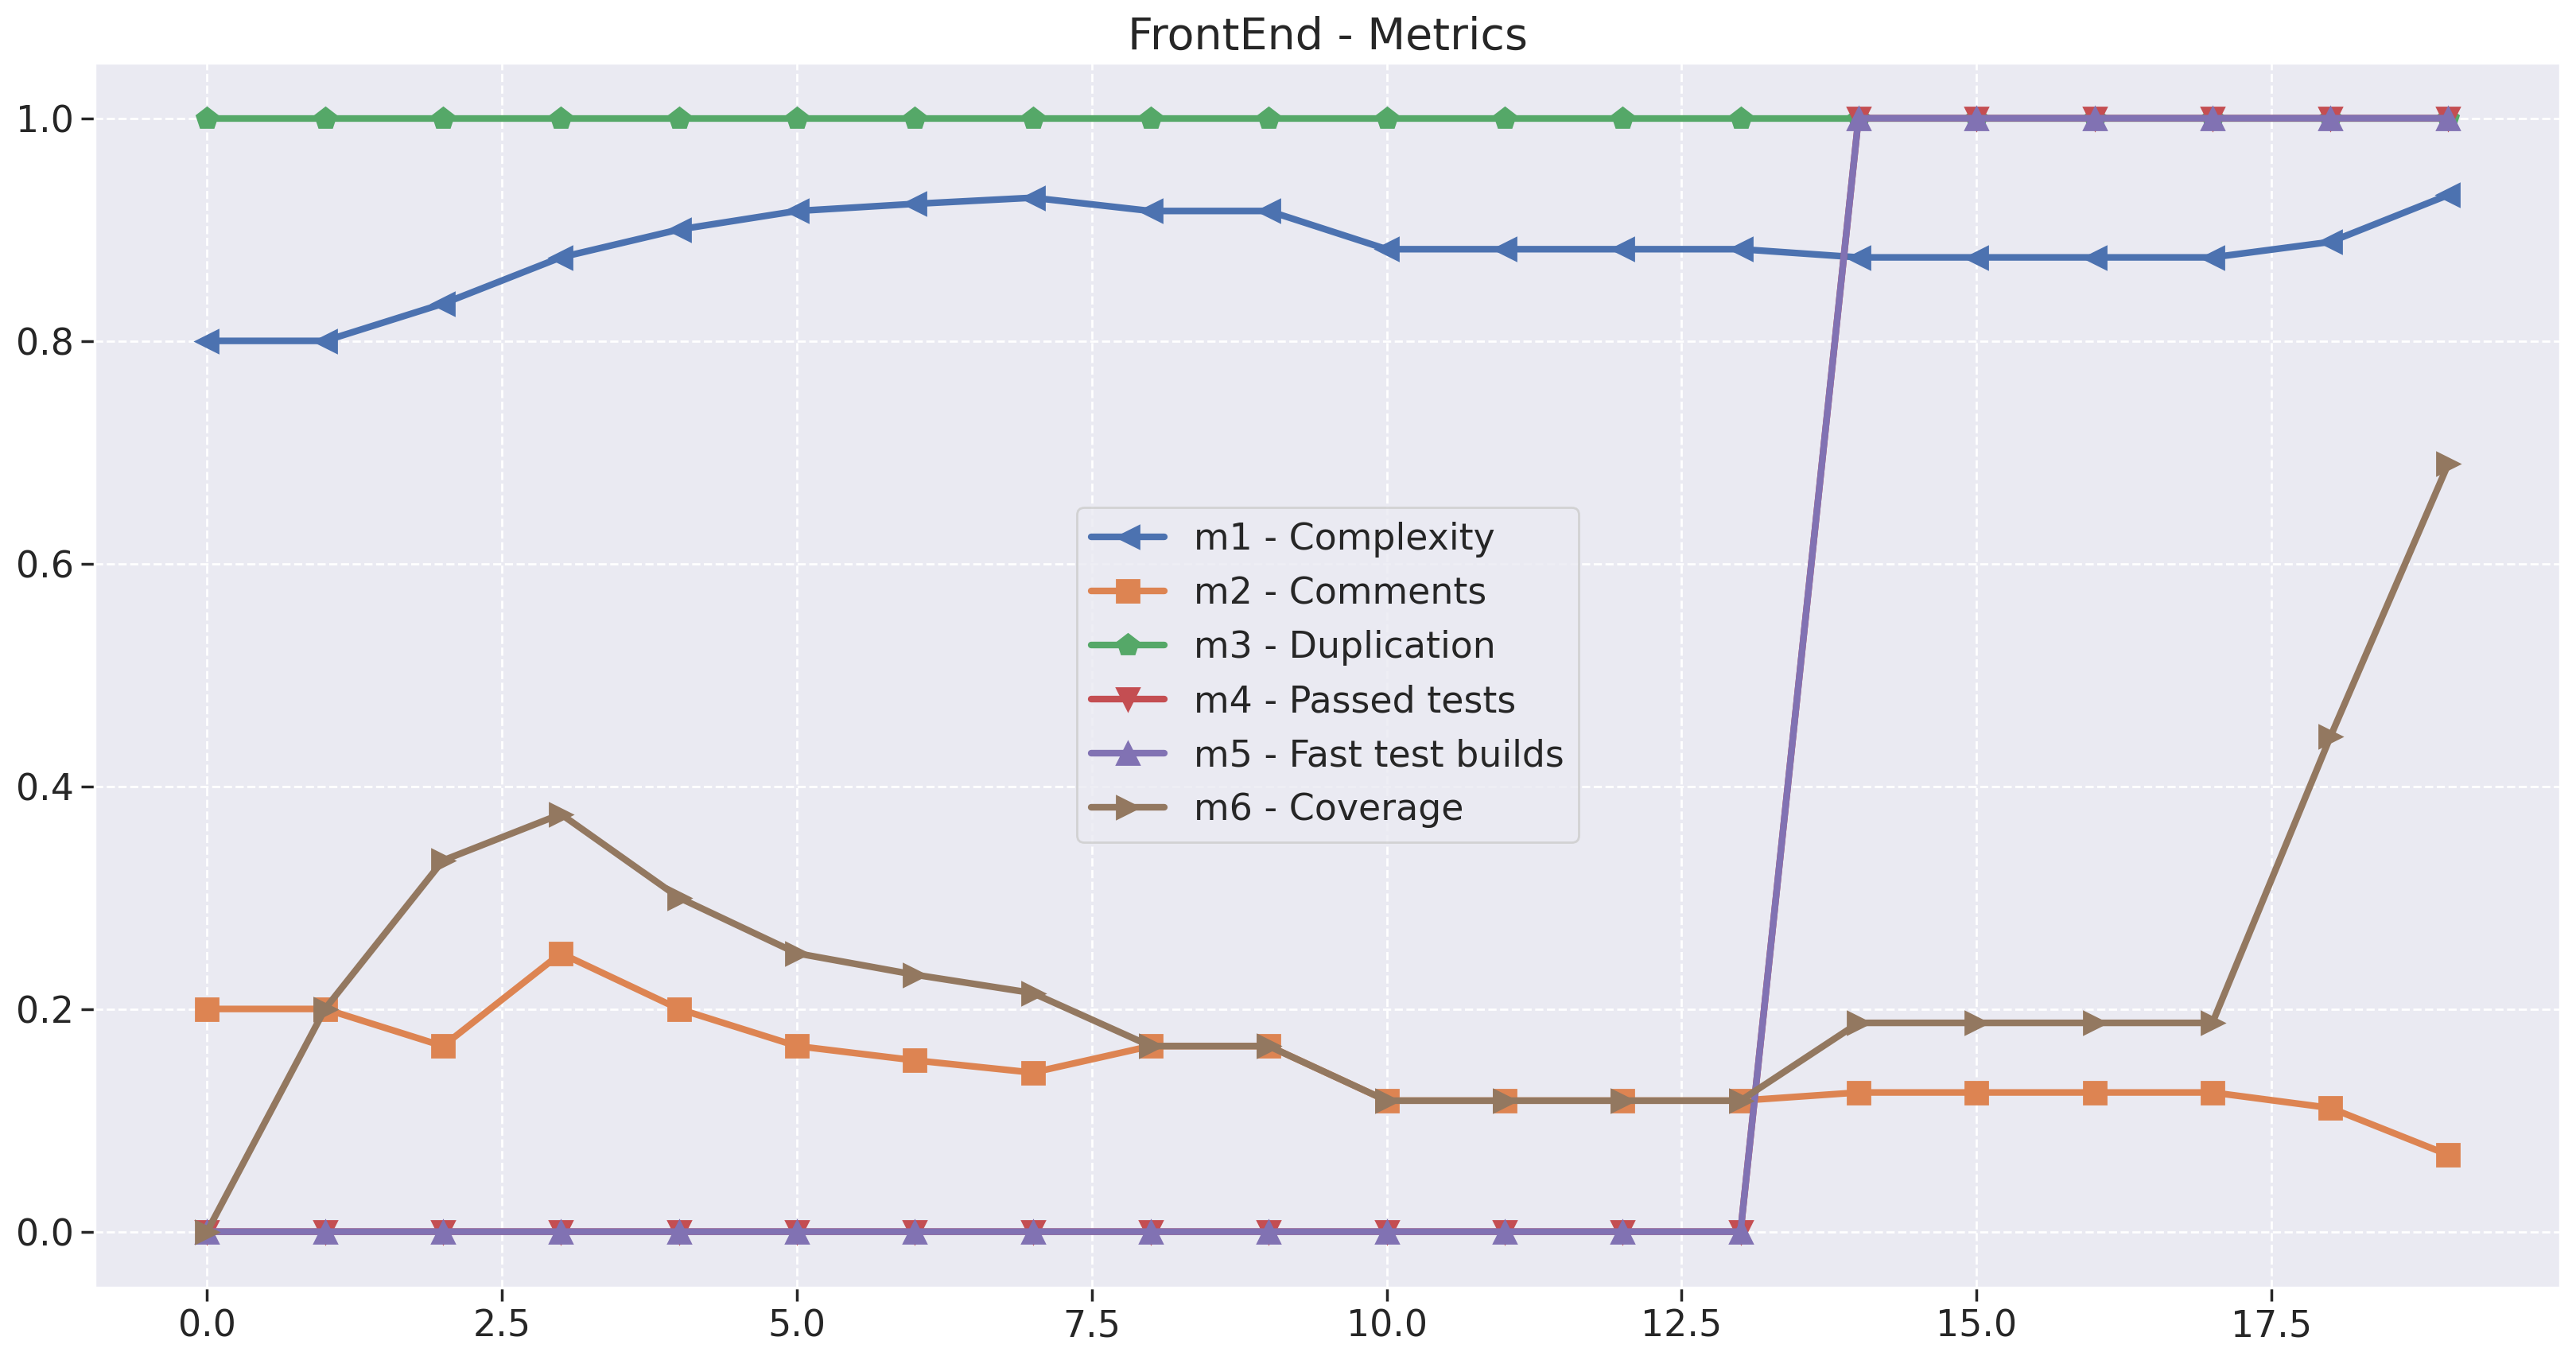

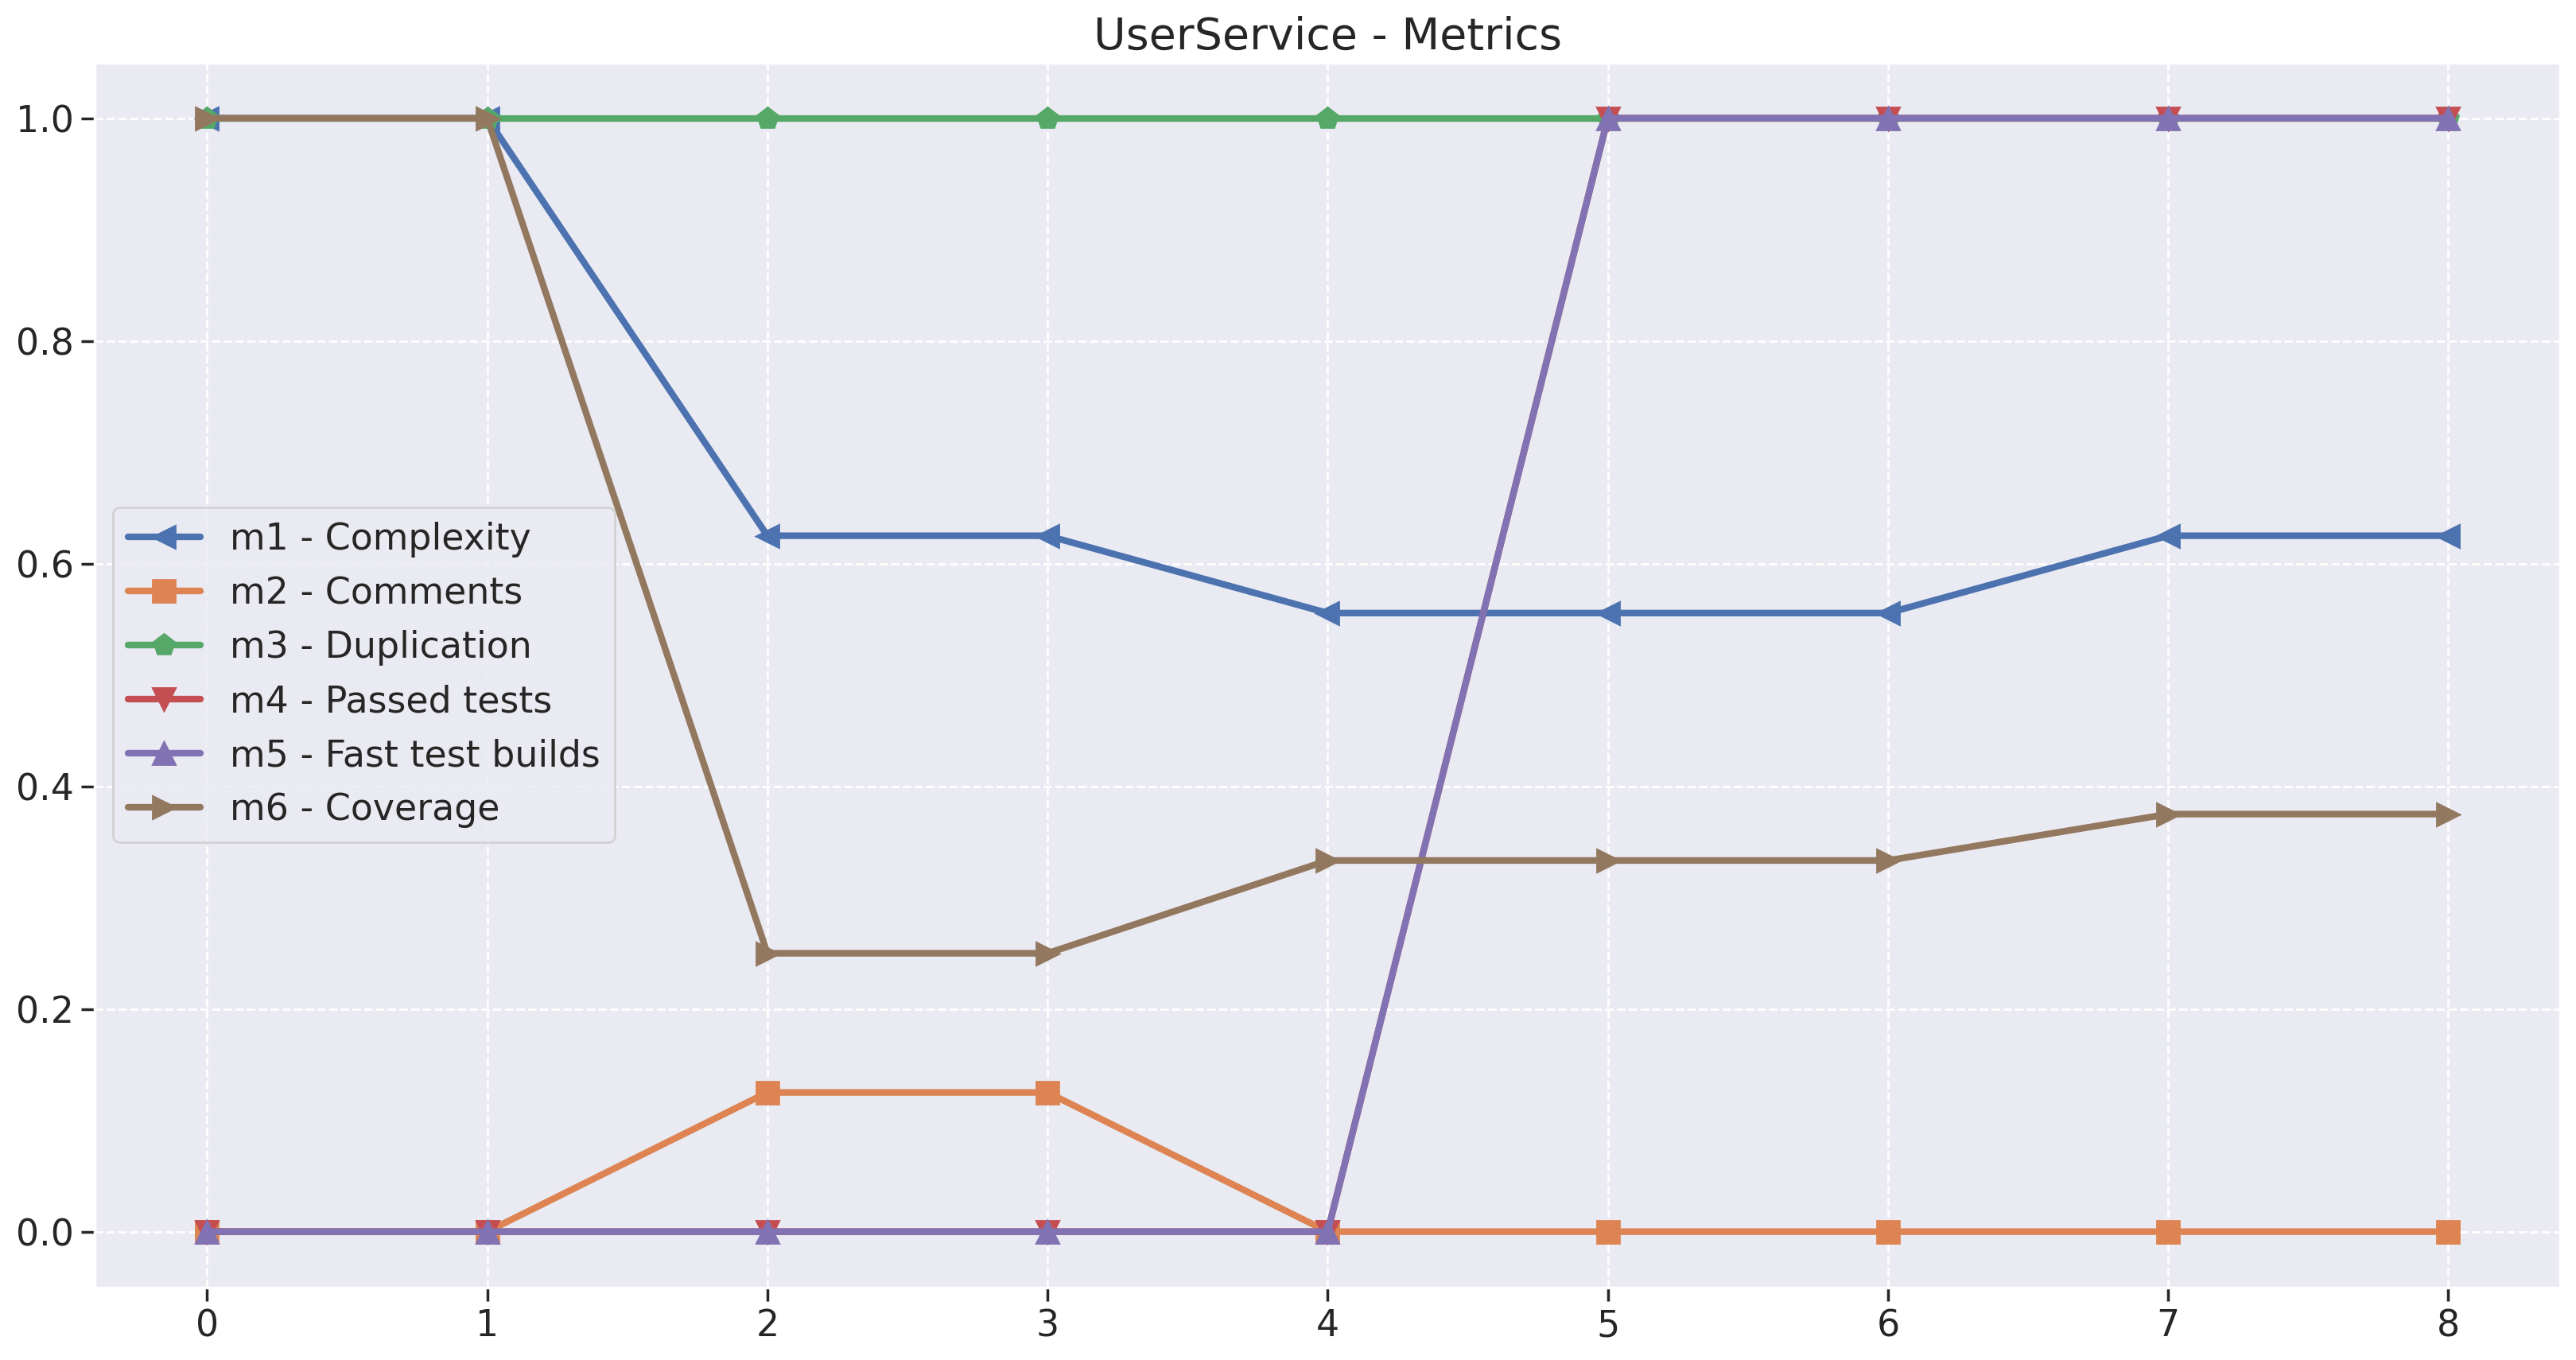

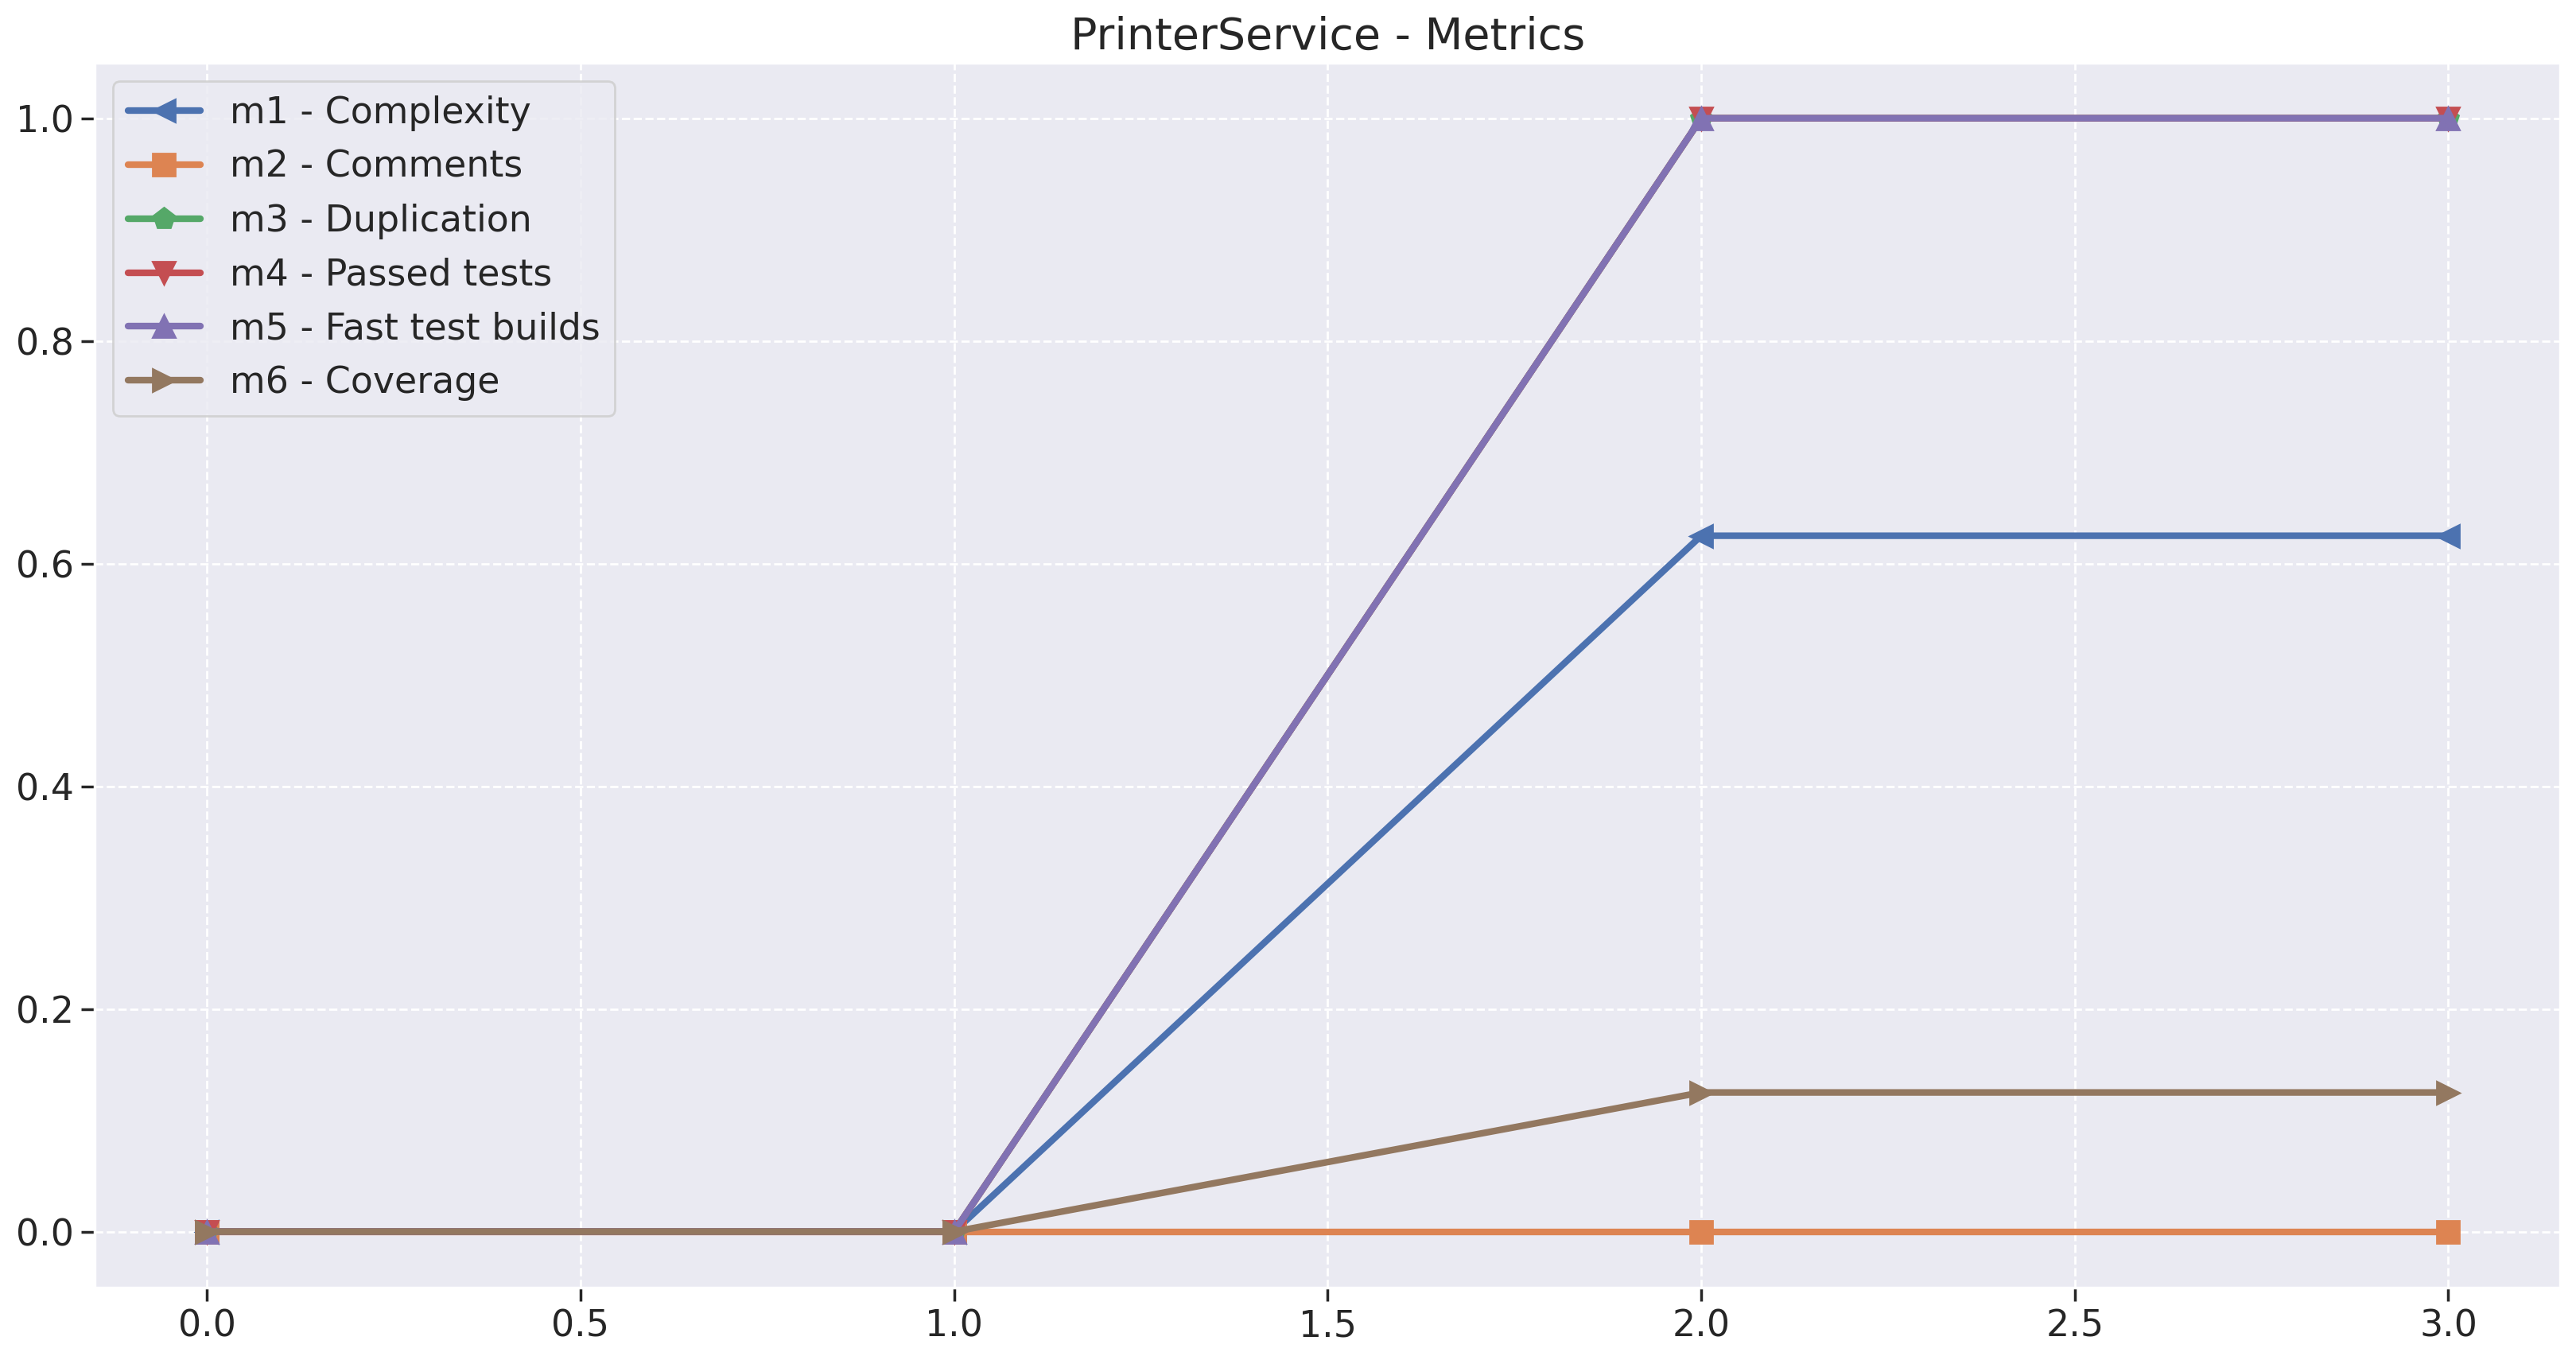

In [576]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='<', markersize=10, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='p', markersize=10, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='v', markersize=10, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='^', markersize=10, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='>', markersize=10, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [577]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

### Code Quality visualization

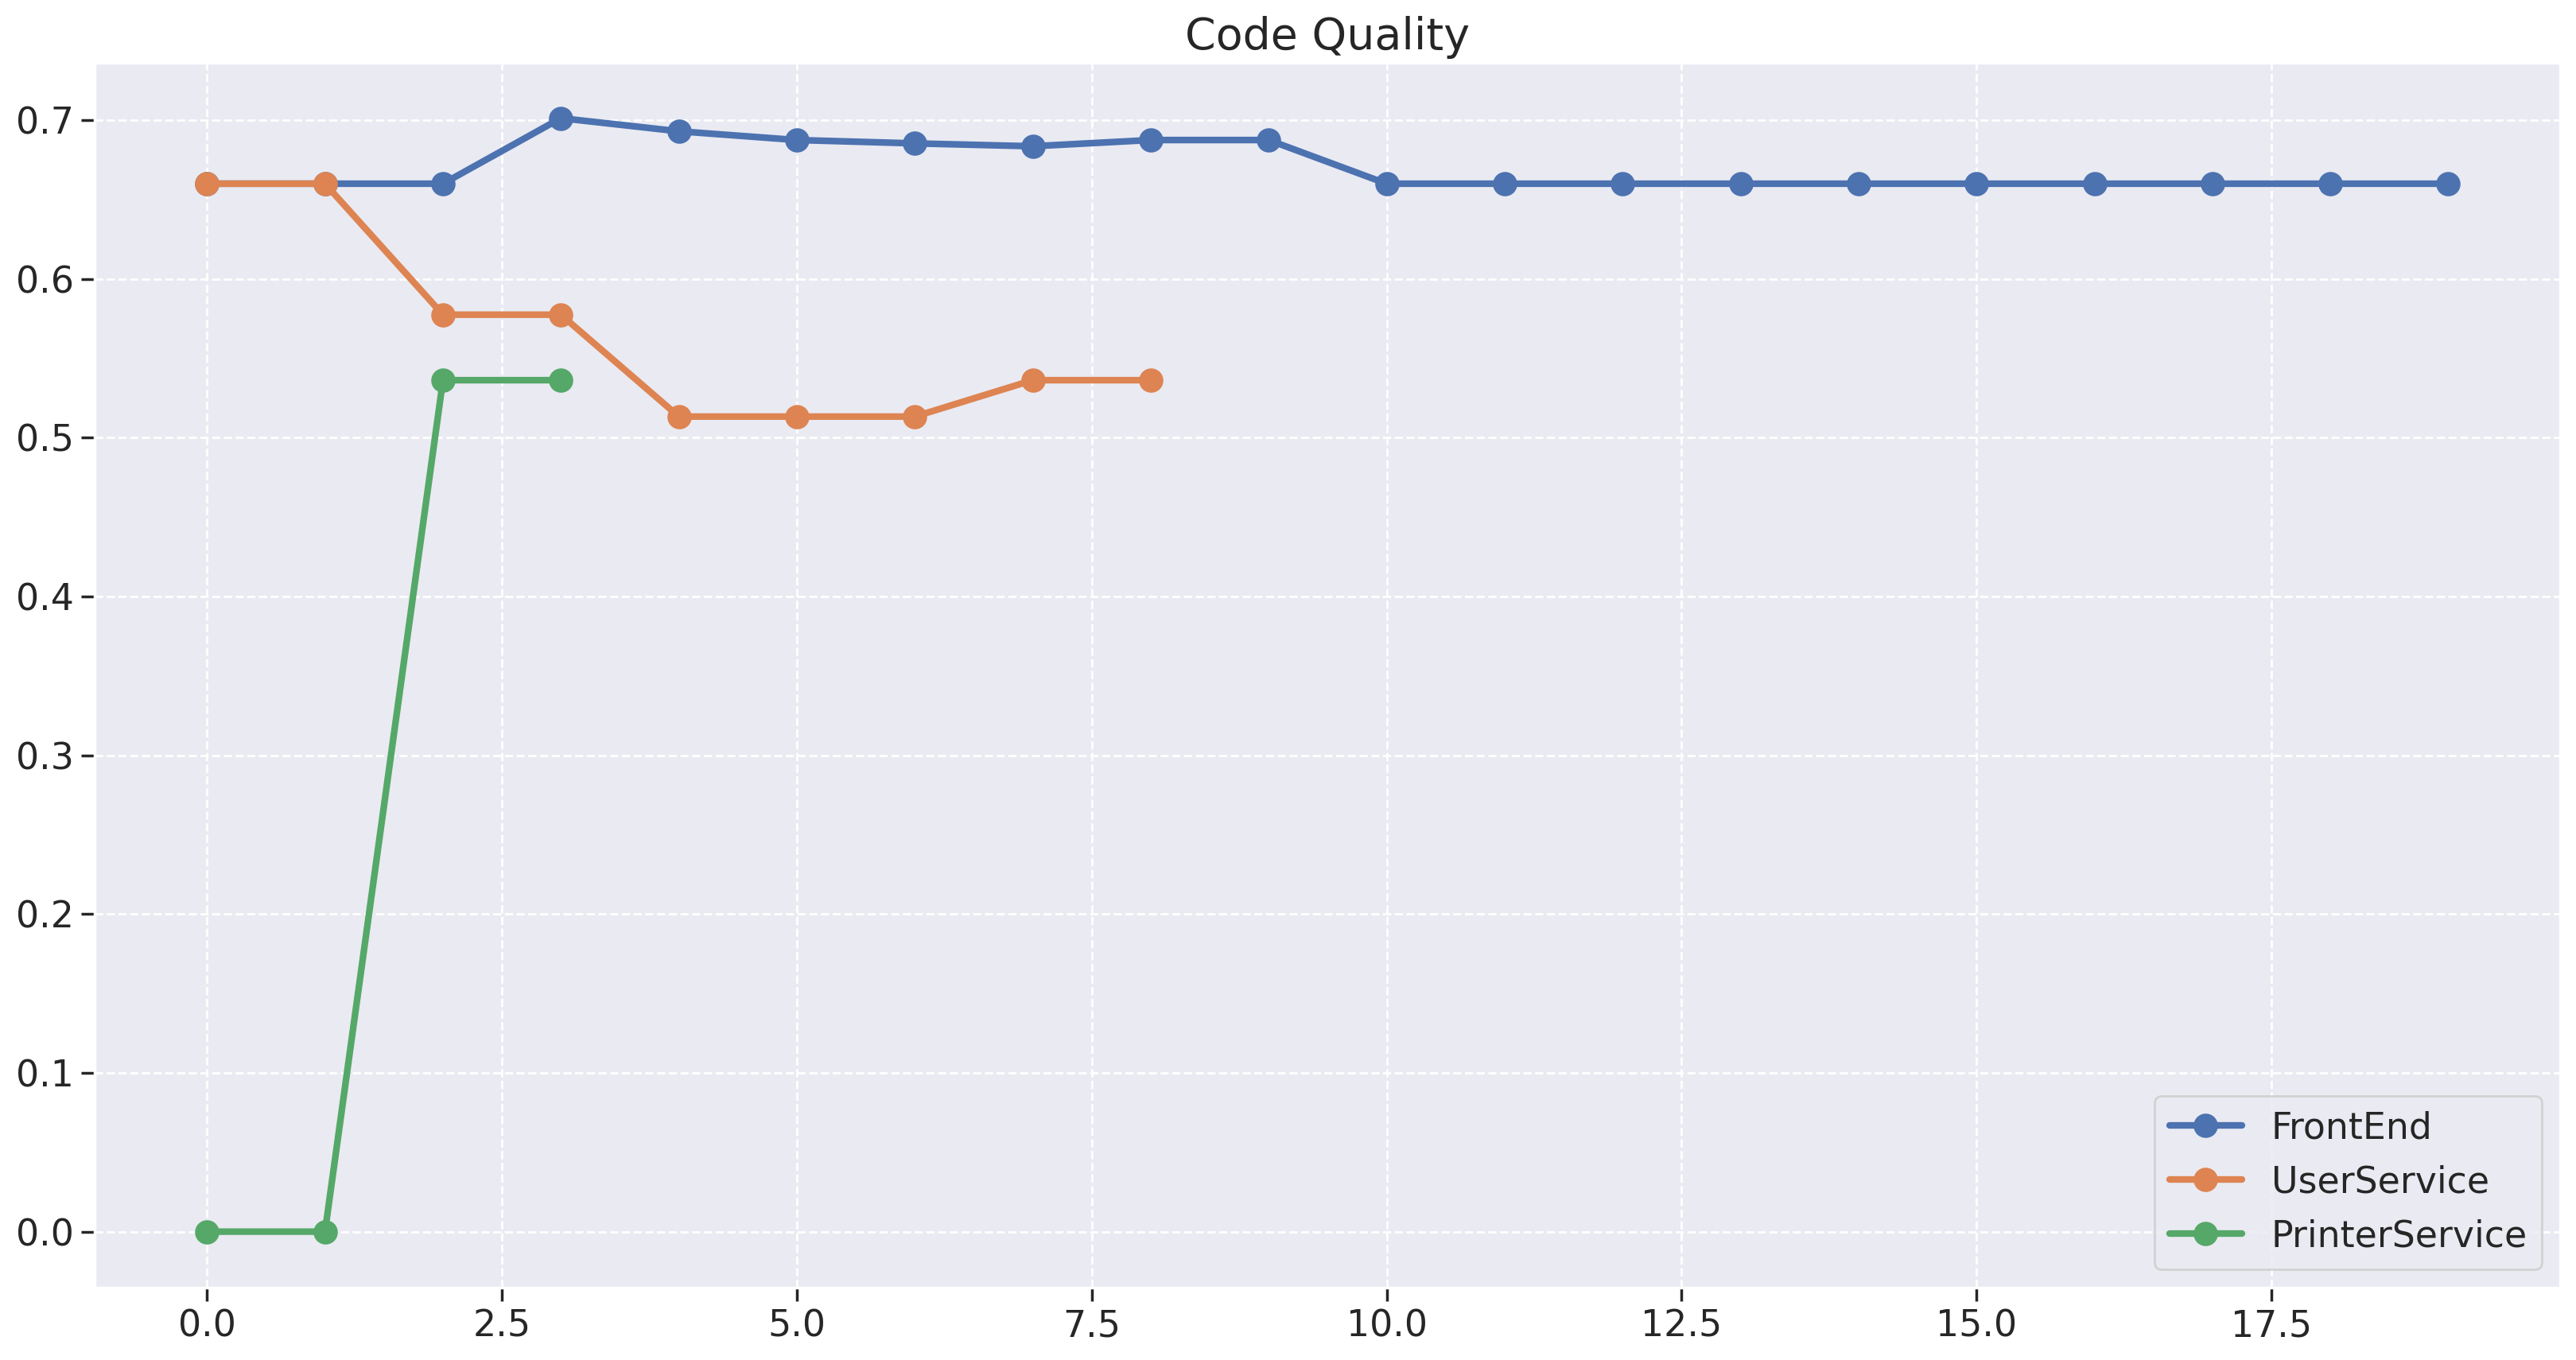

In [578]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

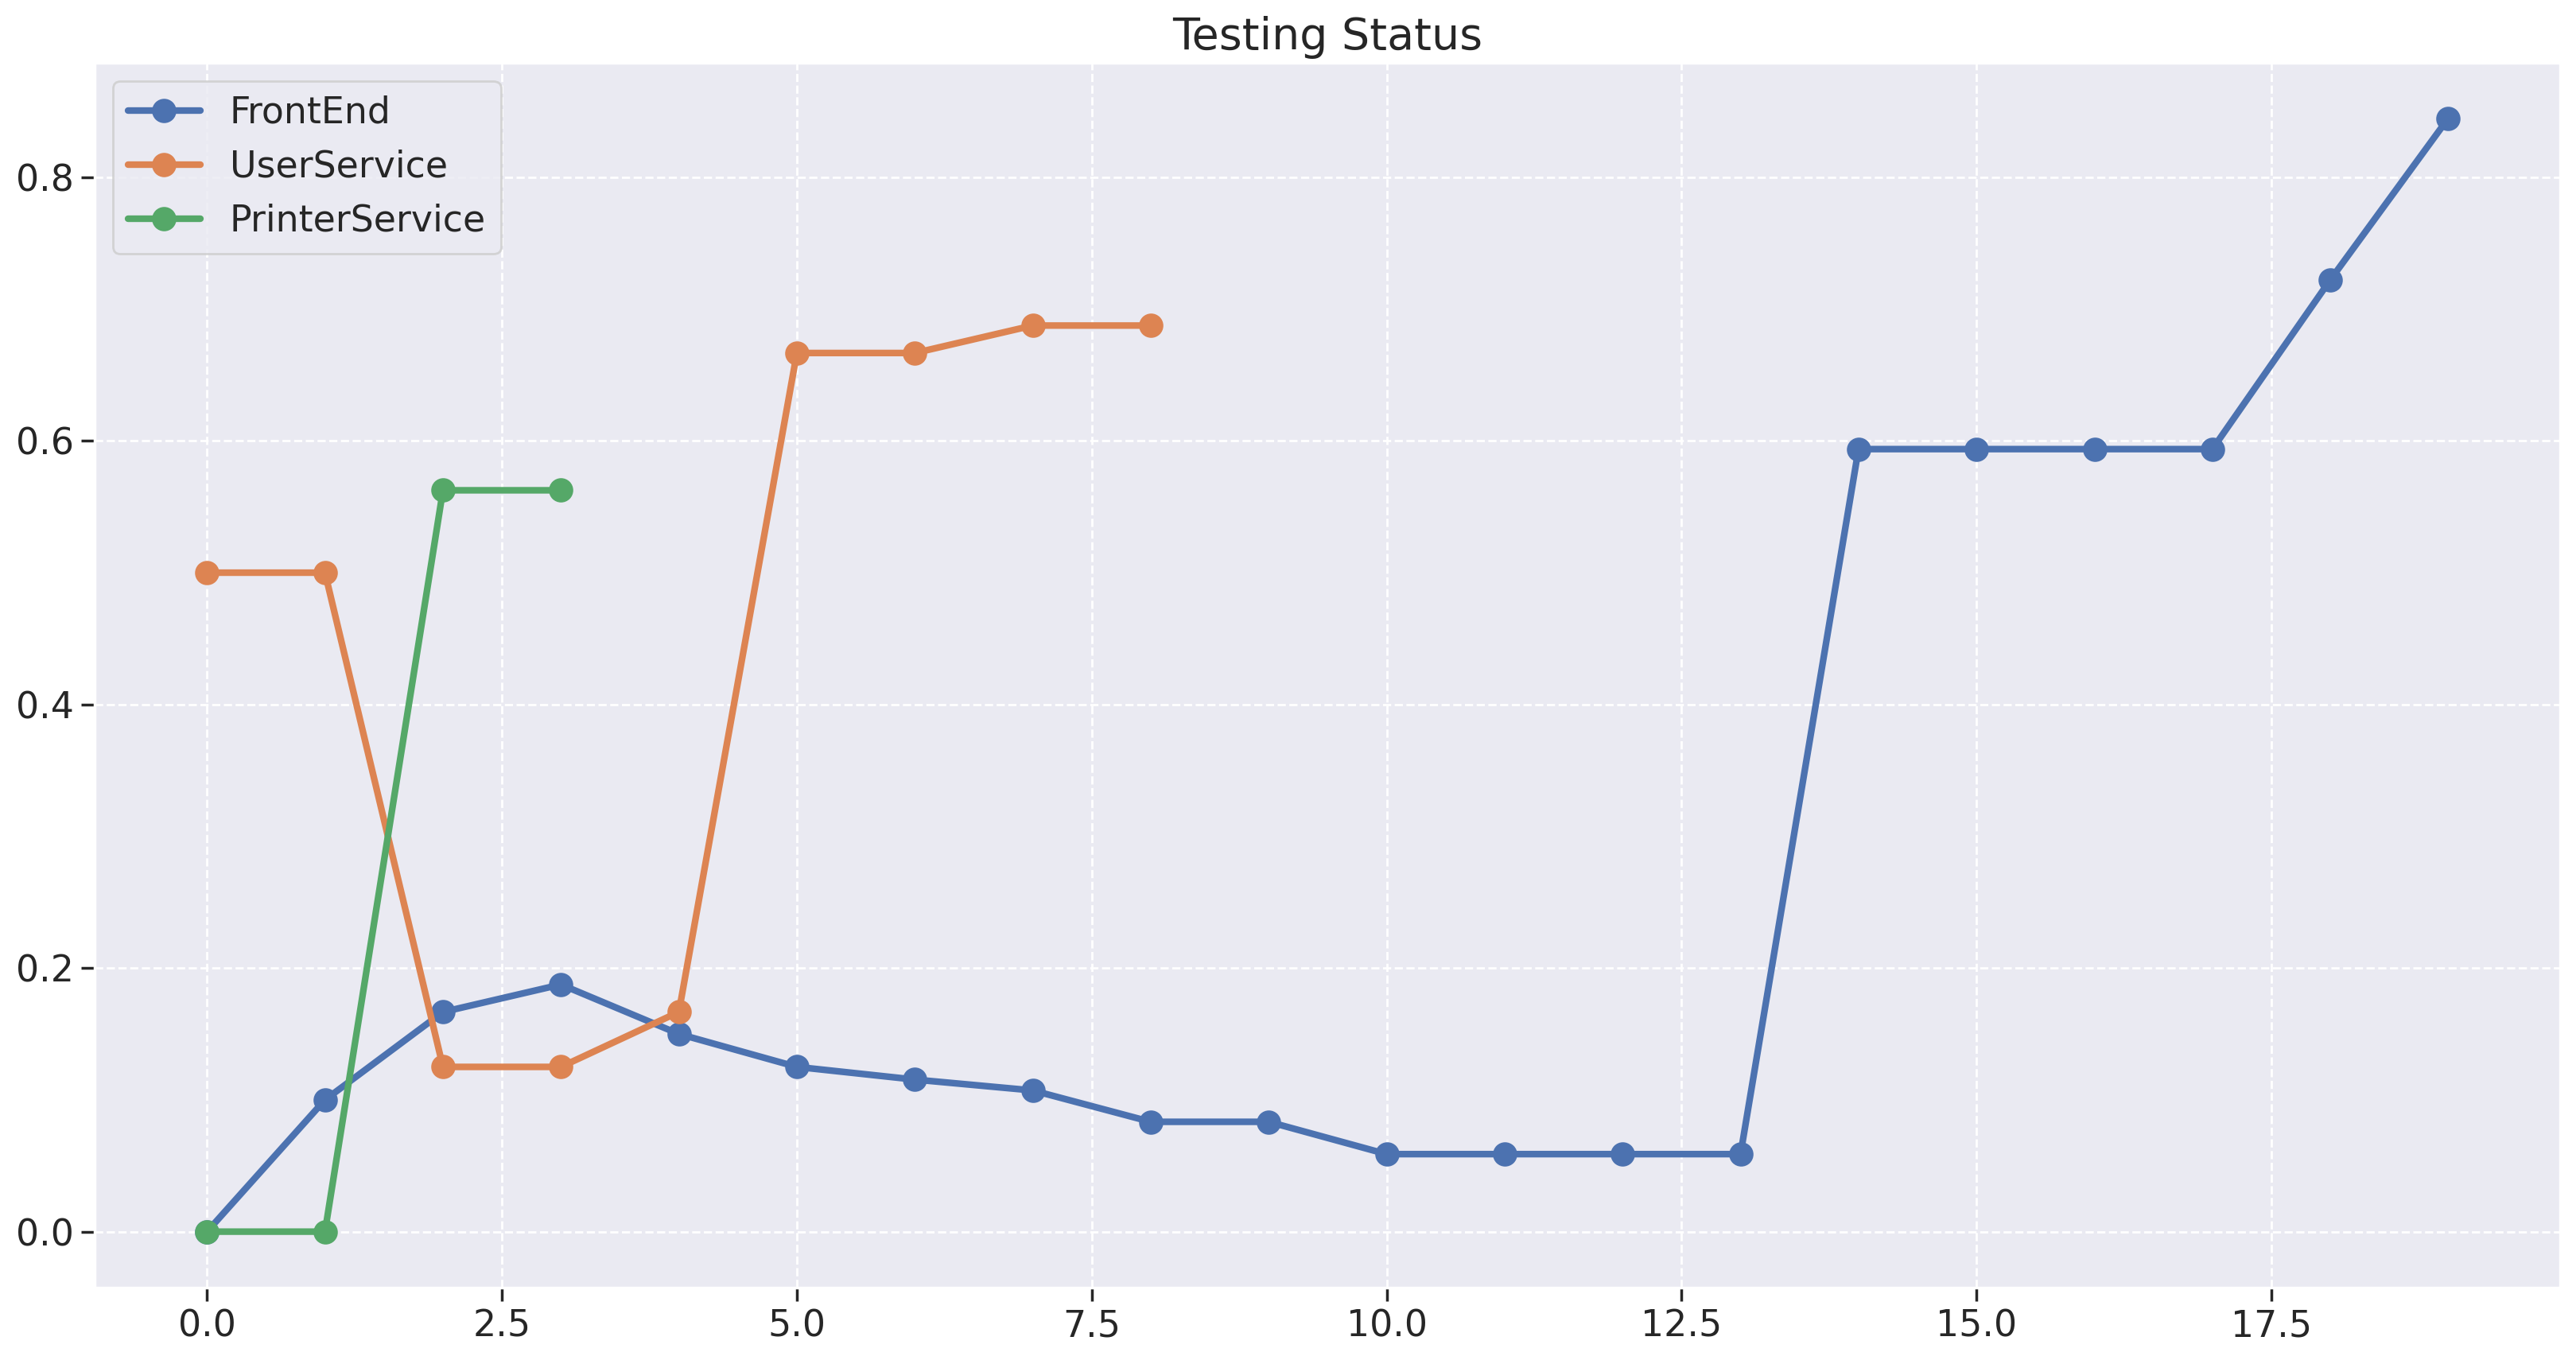

In [579]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [580]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [581]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [582]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

FrontEnd
Maintainability Stats
    mean  mode  median      std      var  min      max
0.335143  0.33    0.33 0.007384 0.000055 0.33 0.350625
Reliability Stats
    mean     mode   median      std      var  min      max
0.132393 0.029412 0.060096 0.136056 0.018511  0.0 0.422414
0.132393 0.296875 0.060096 0.136056 0.018511  0.0 0.422414


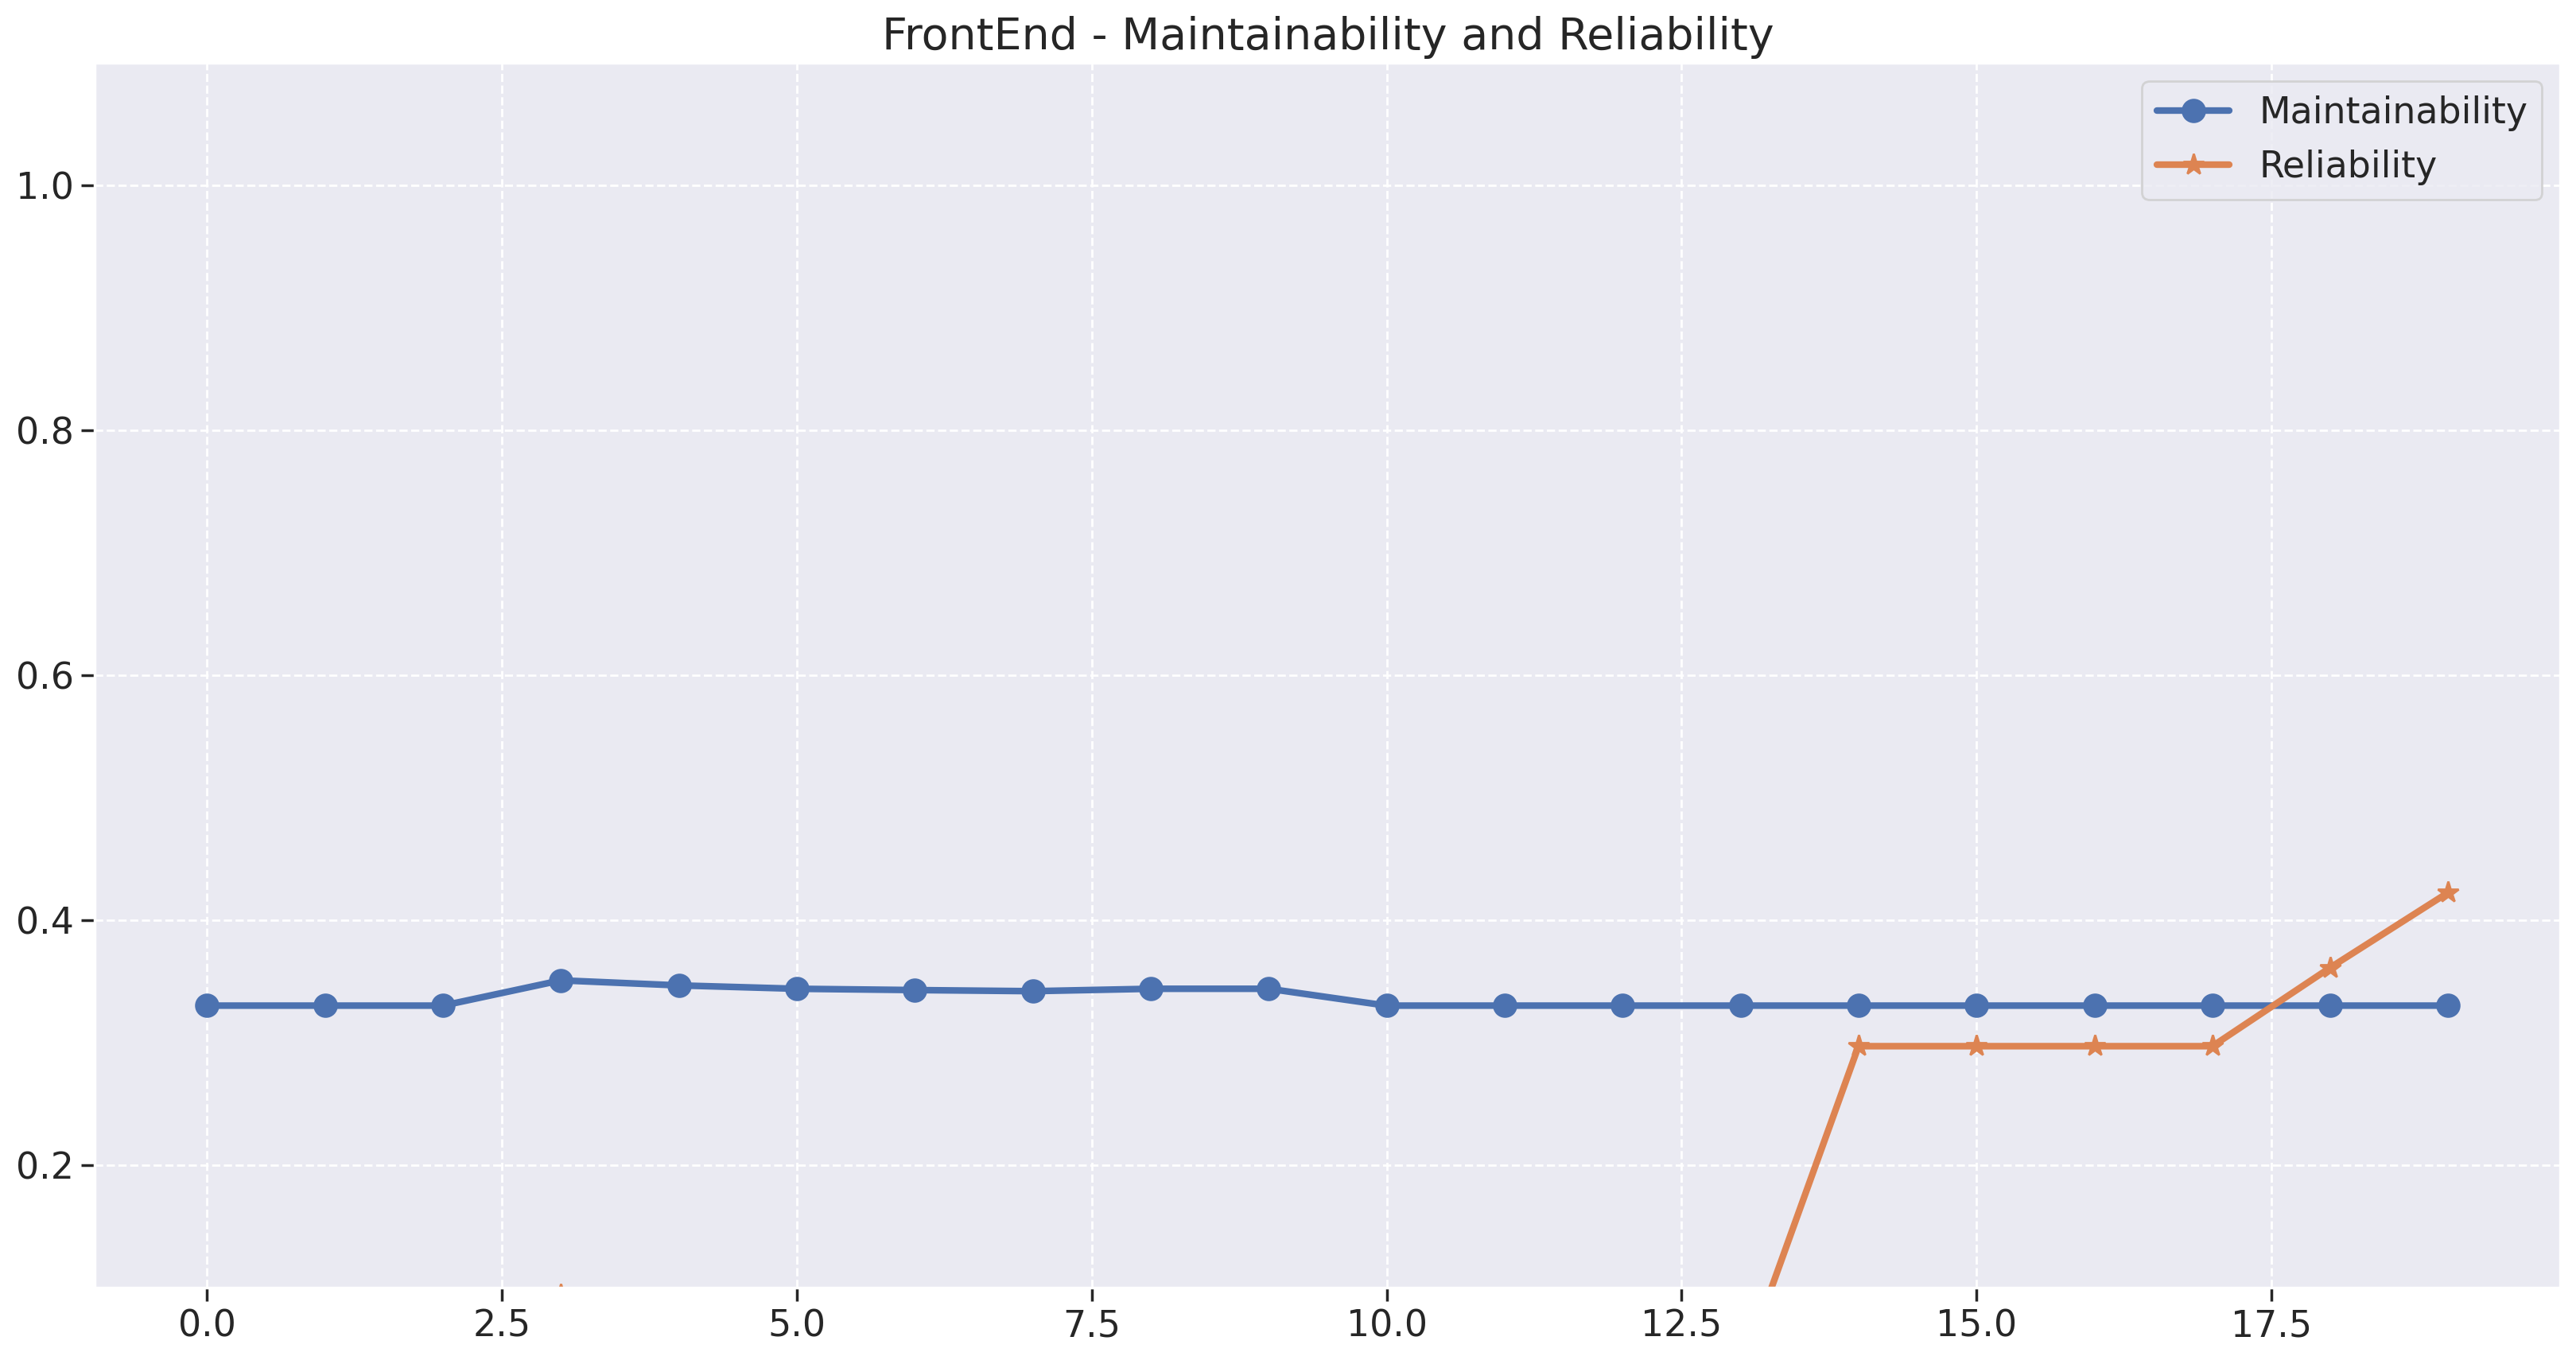

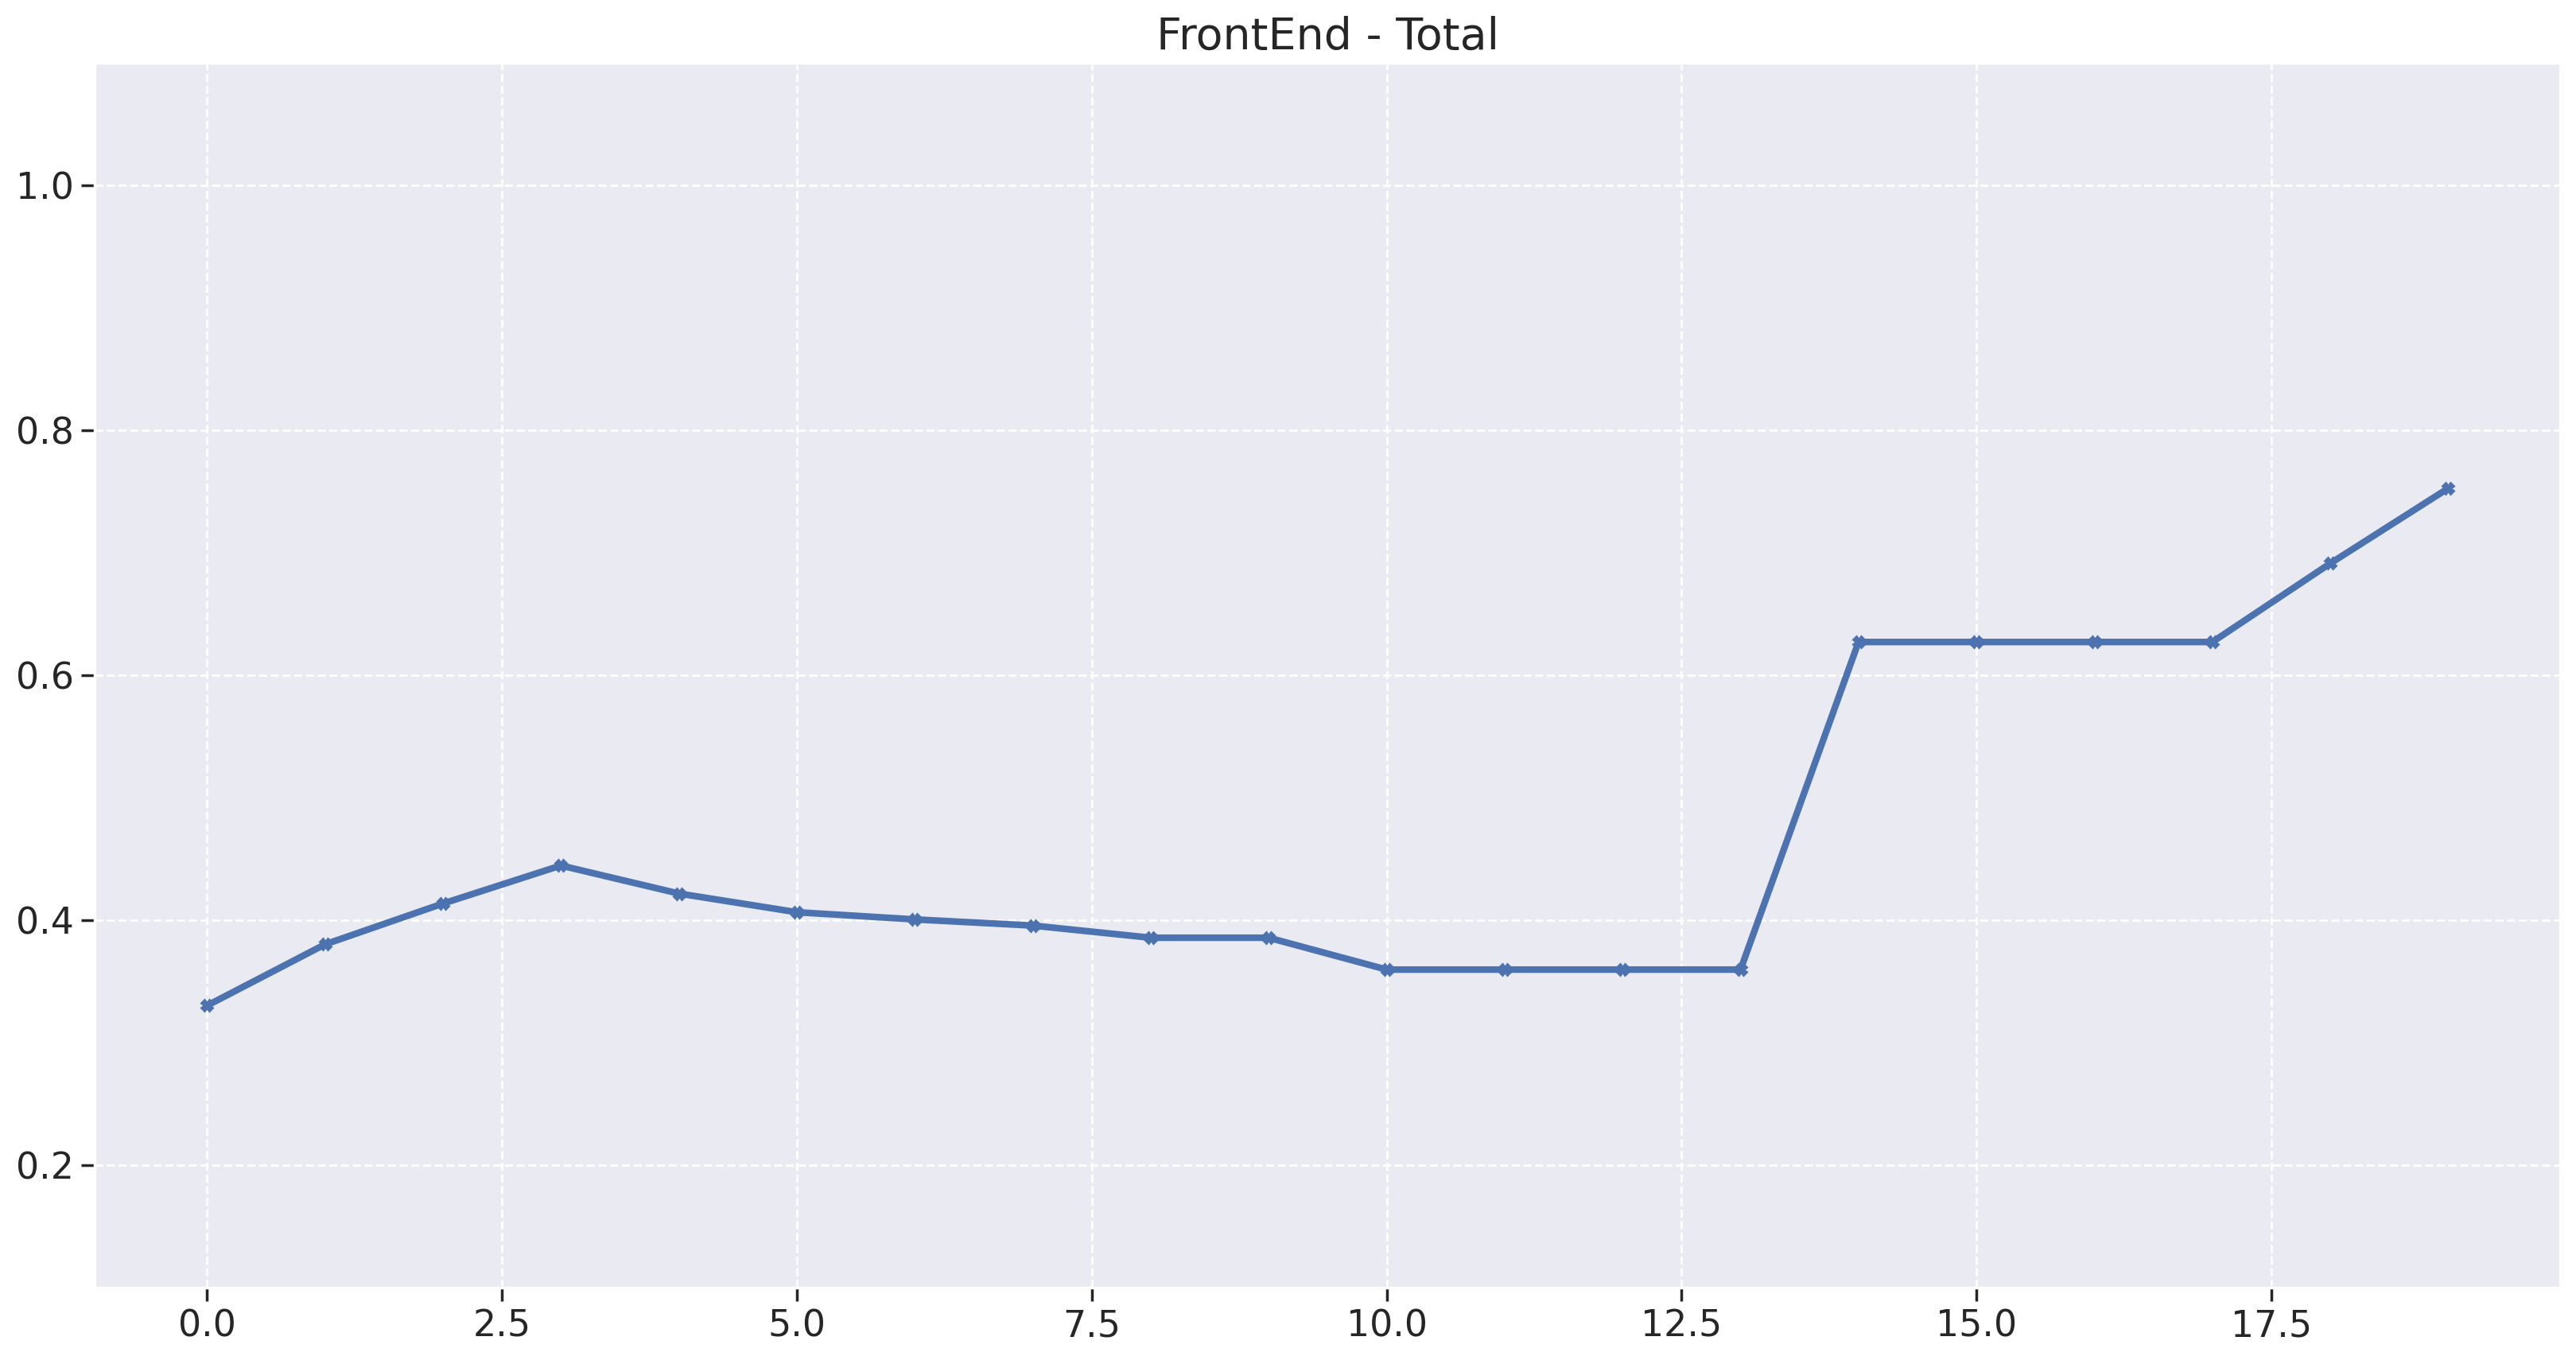

UserService
Maintainability Stats
    mean     mode   median      std      var      min  max
0.282639 0.256667 0.268125 0.029593 0.000876 0.256667 0.33
Reliability Stats
    mean     mode  median      std      var    min     max
0.229167 0.062500    0.25 0.125325 0.015706 0.0625 0.34375
0.229167 0.250000    0.25 0.125325 0.015706 0.0625 0.34375
0.229167 0.333333    0.25 0.125325 0.015706 0.0625 0.34375
0.229167 0.343750    0.25 0.125325 0.015706 0.0625 0.34375


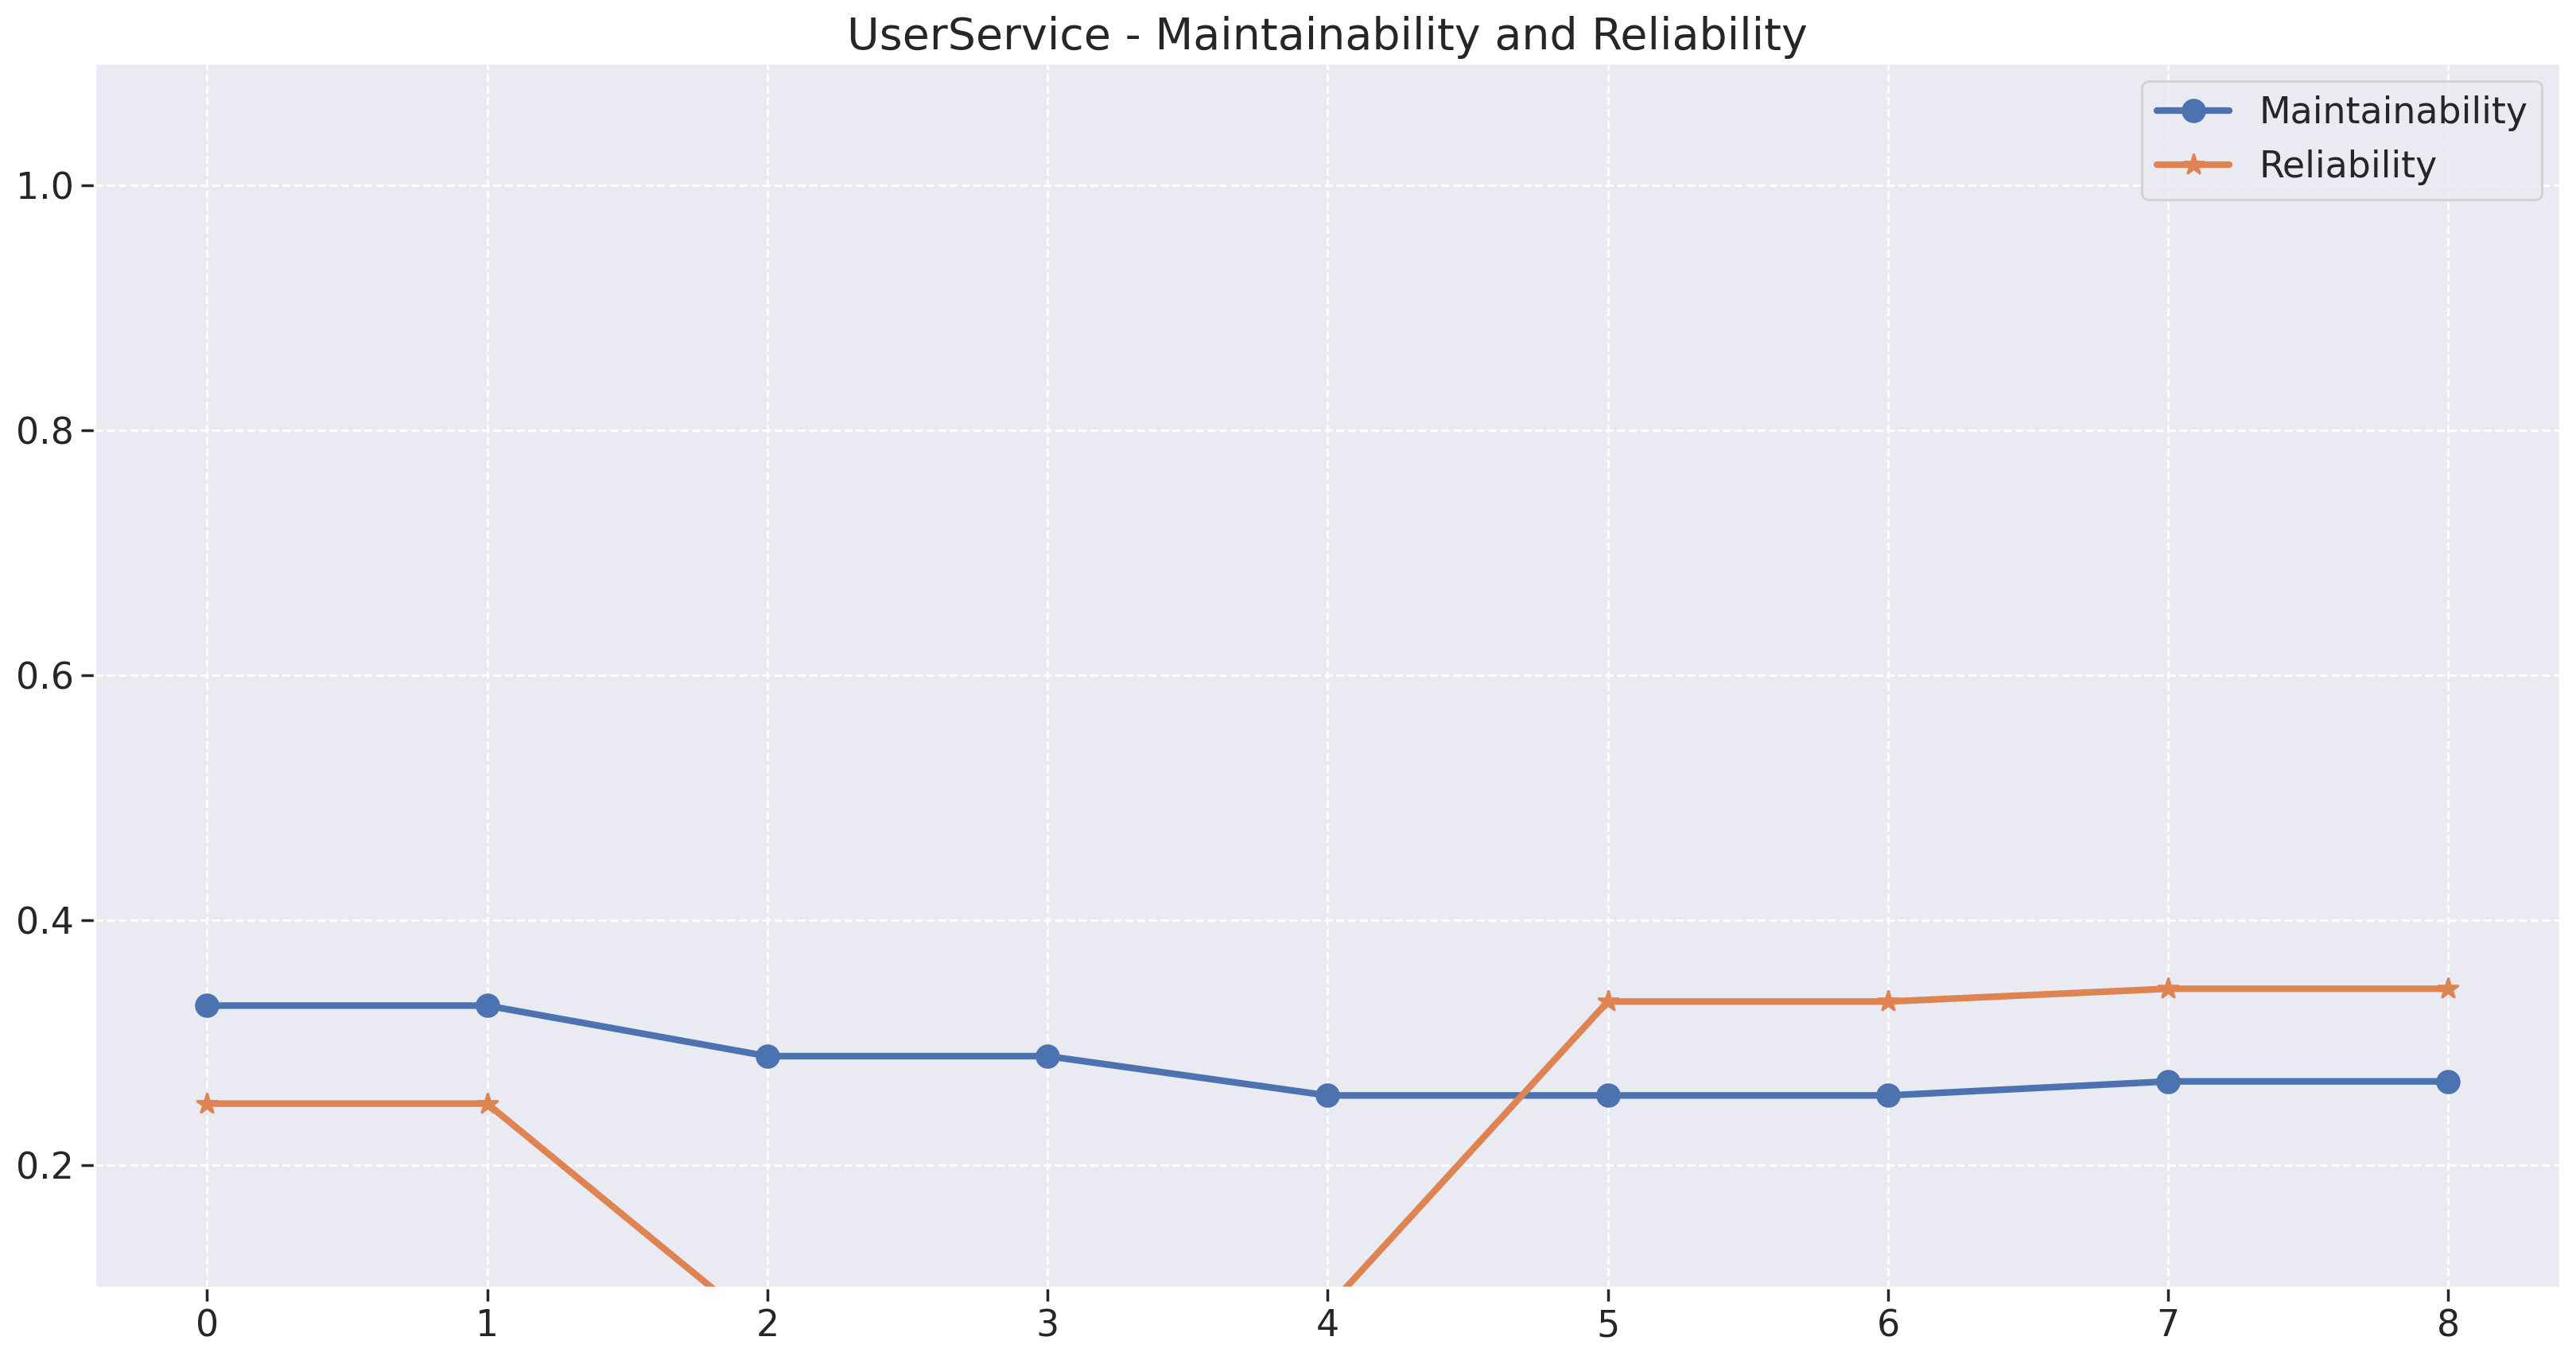

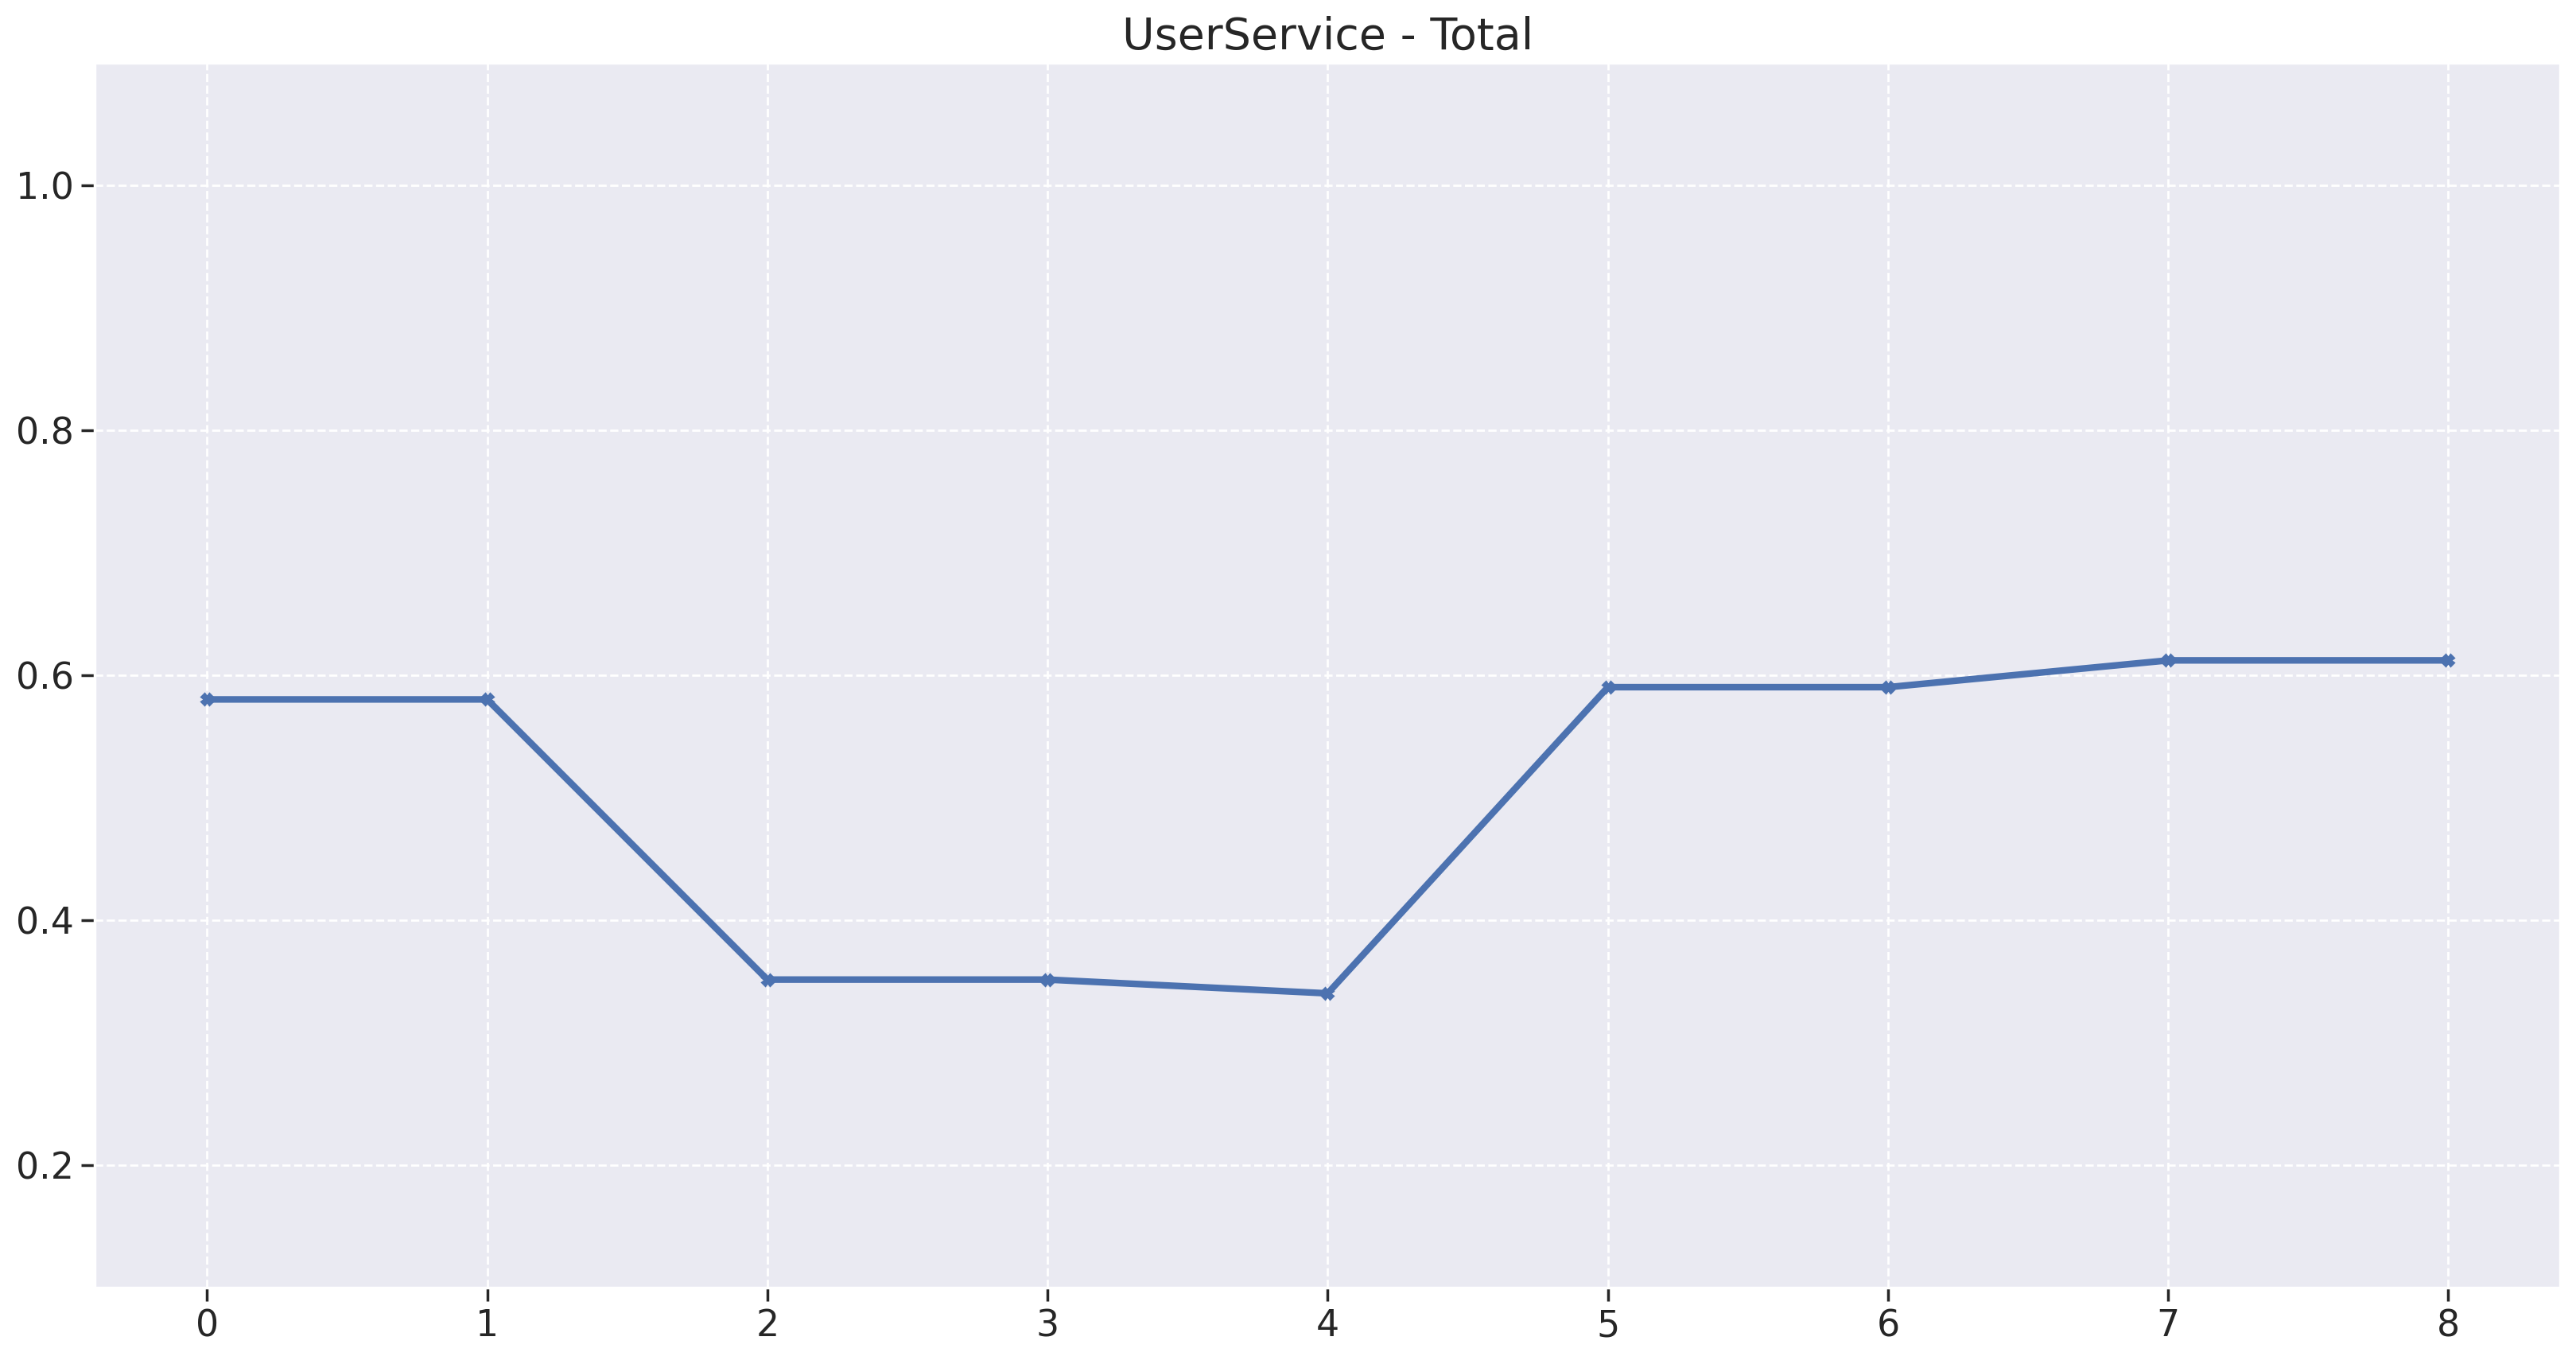

PrinterService
Maintainability Stats
    mean     mode   median      std      var  min      max
0.134063 0.000000 0.134063 0.154802 0.023964  0.0 0.268125
0.134063 0.268125 0.134063 0.154802 0.023964  0.0 0.268125
Reliability Stats
    mean    mode   median     std      var  min     max
0.140625 0.00000 0.140625 0.16238 0.026367  0.0 0.28125
0.140625 0.28125 0.140625 0.16238 0.026367  0.0 0.28125


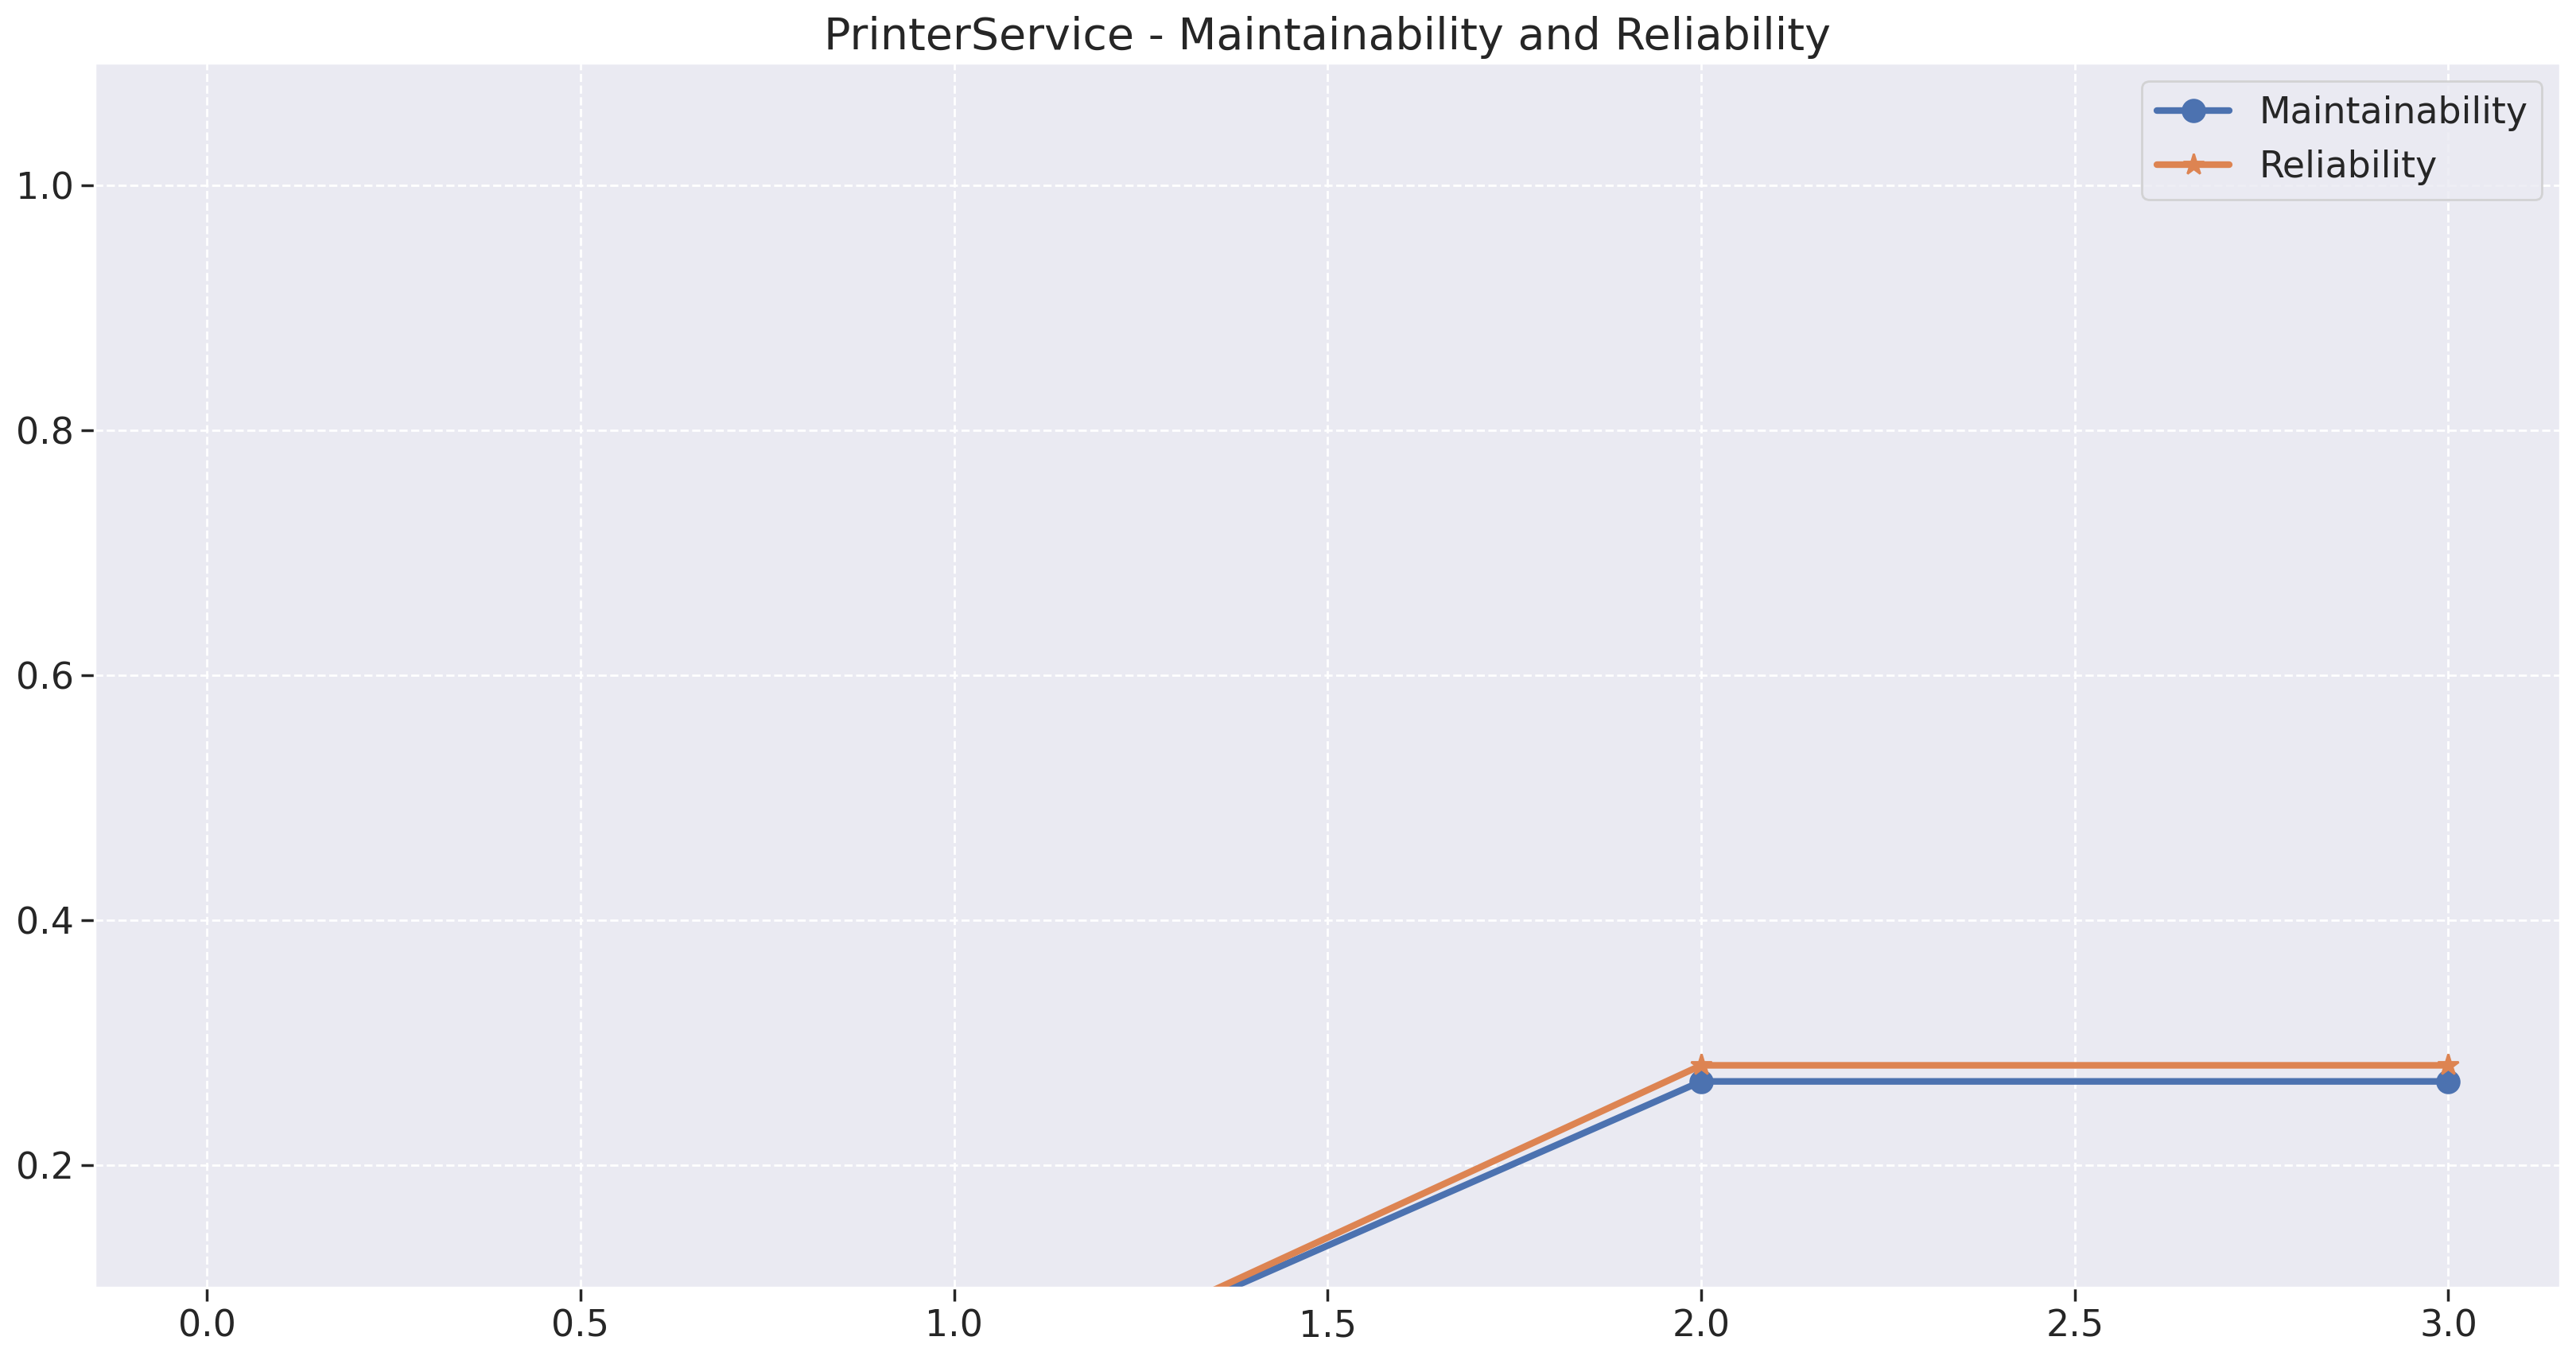

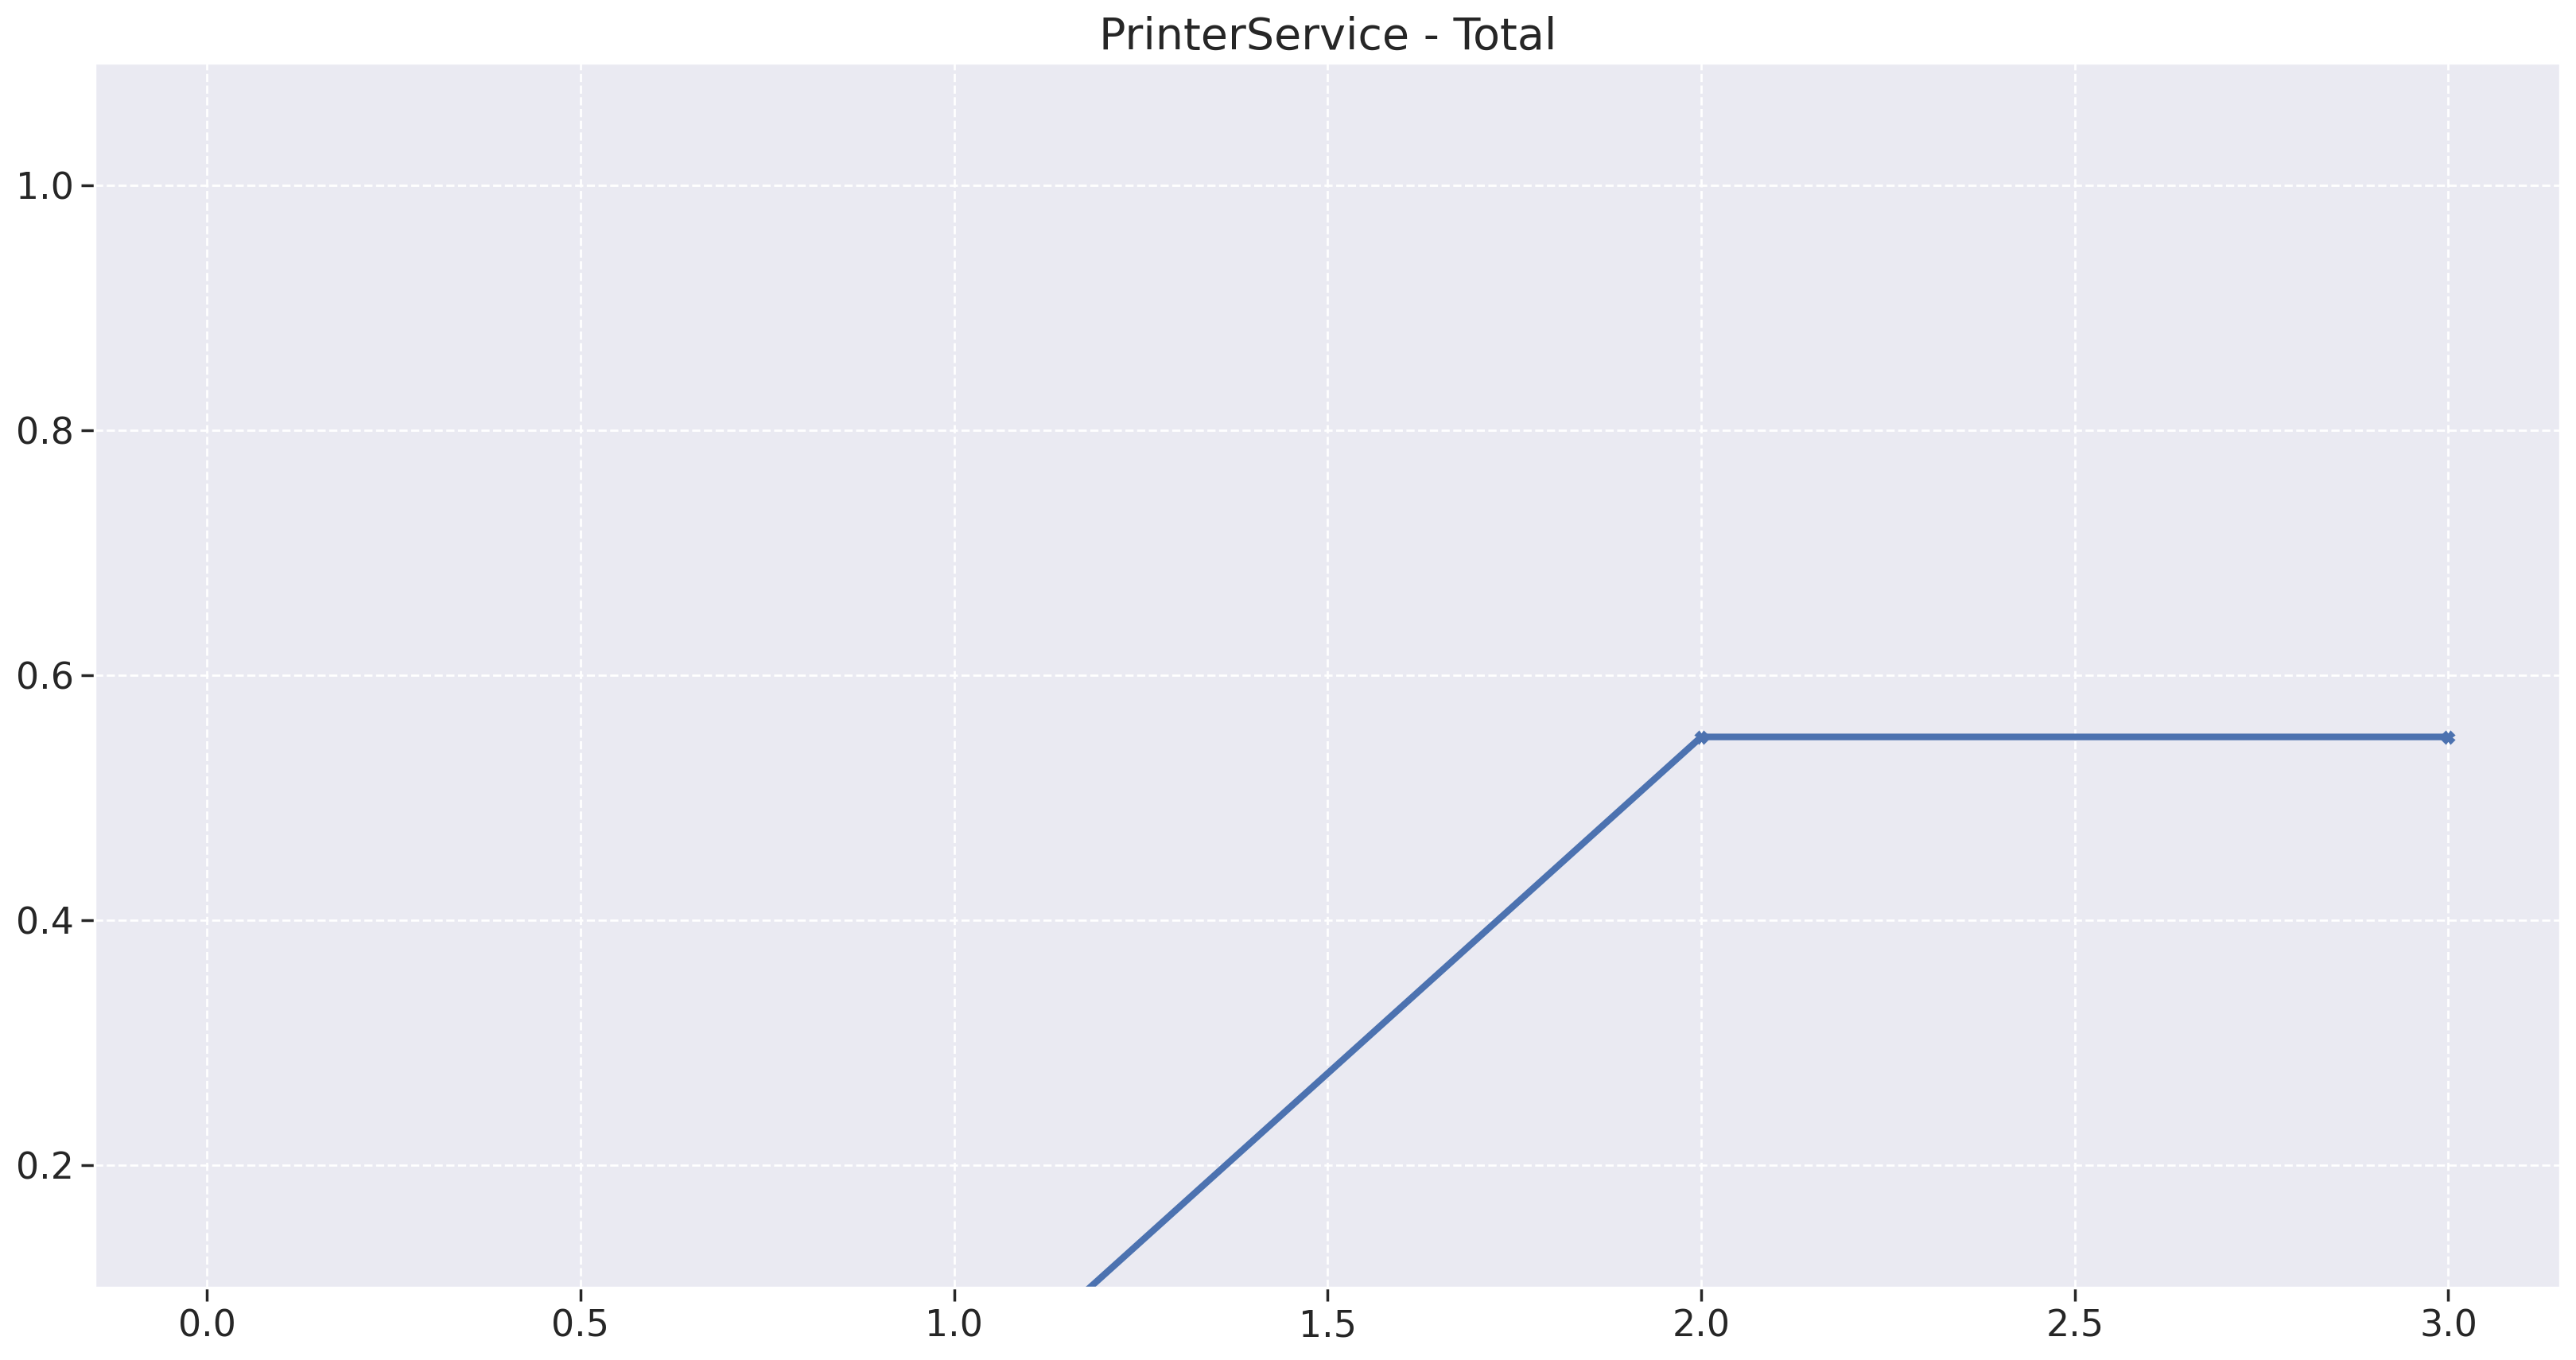

In [583]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

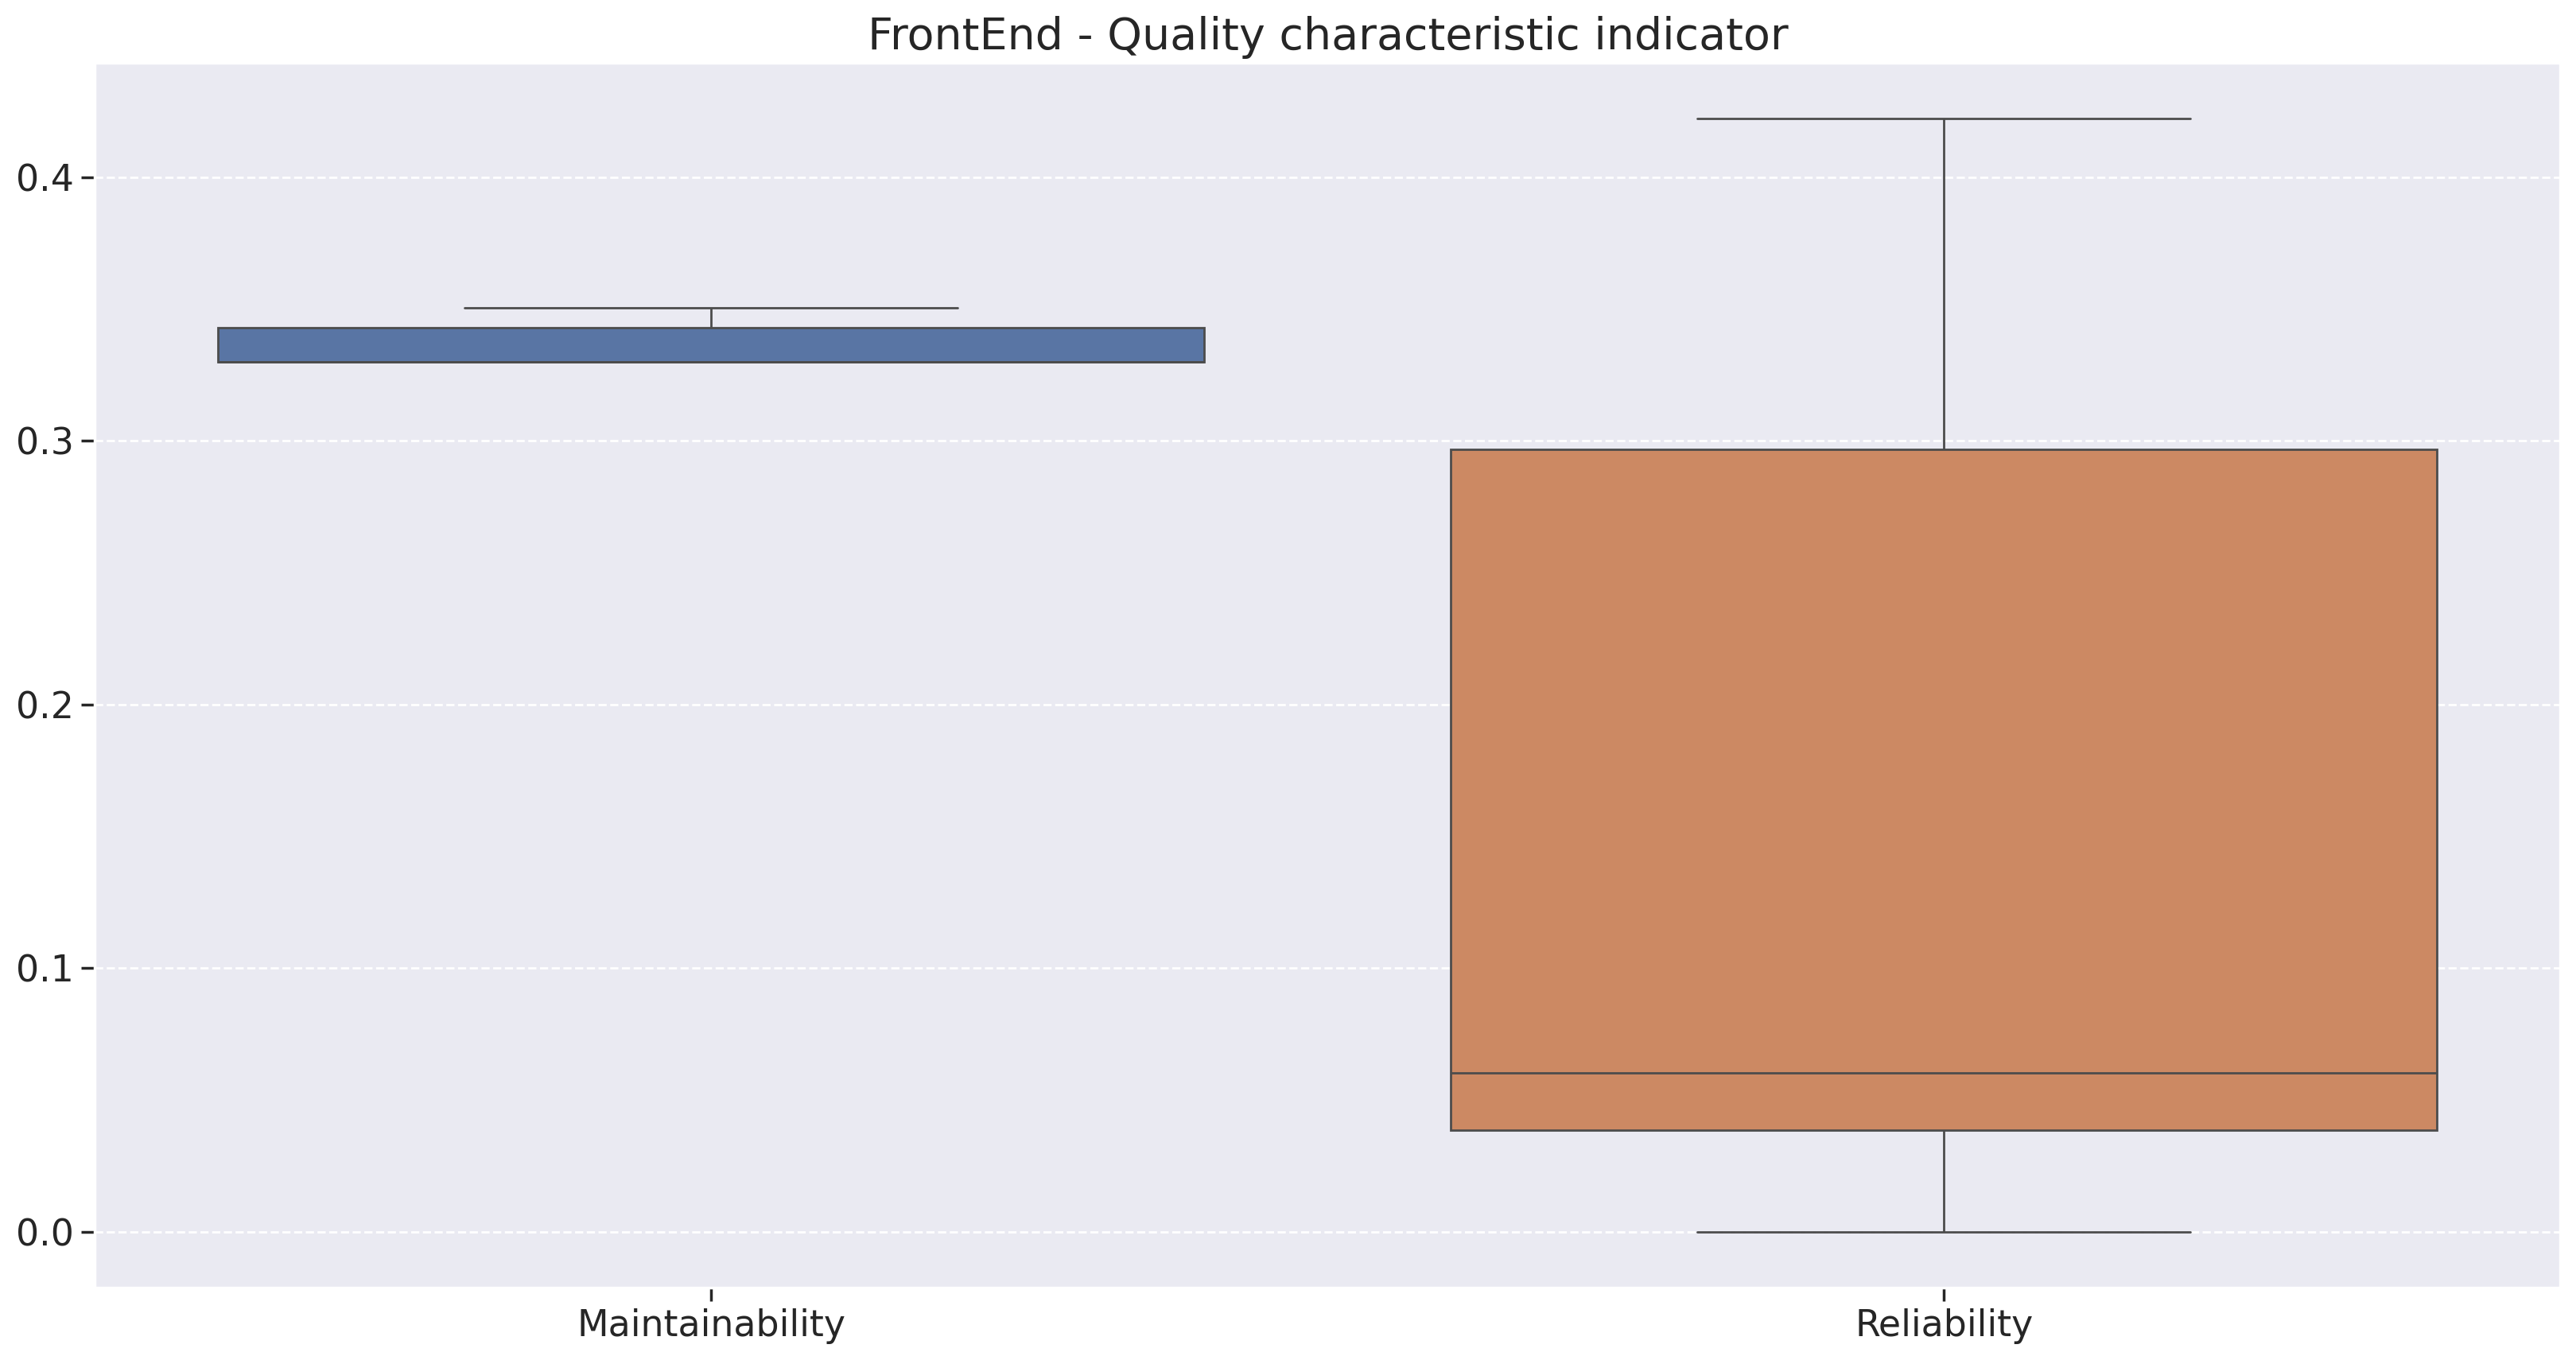

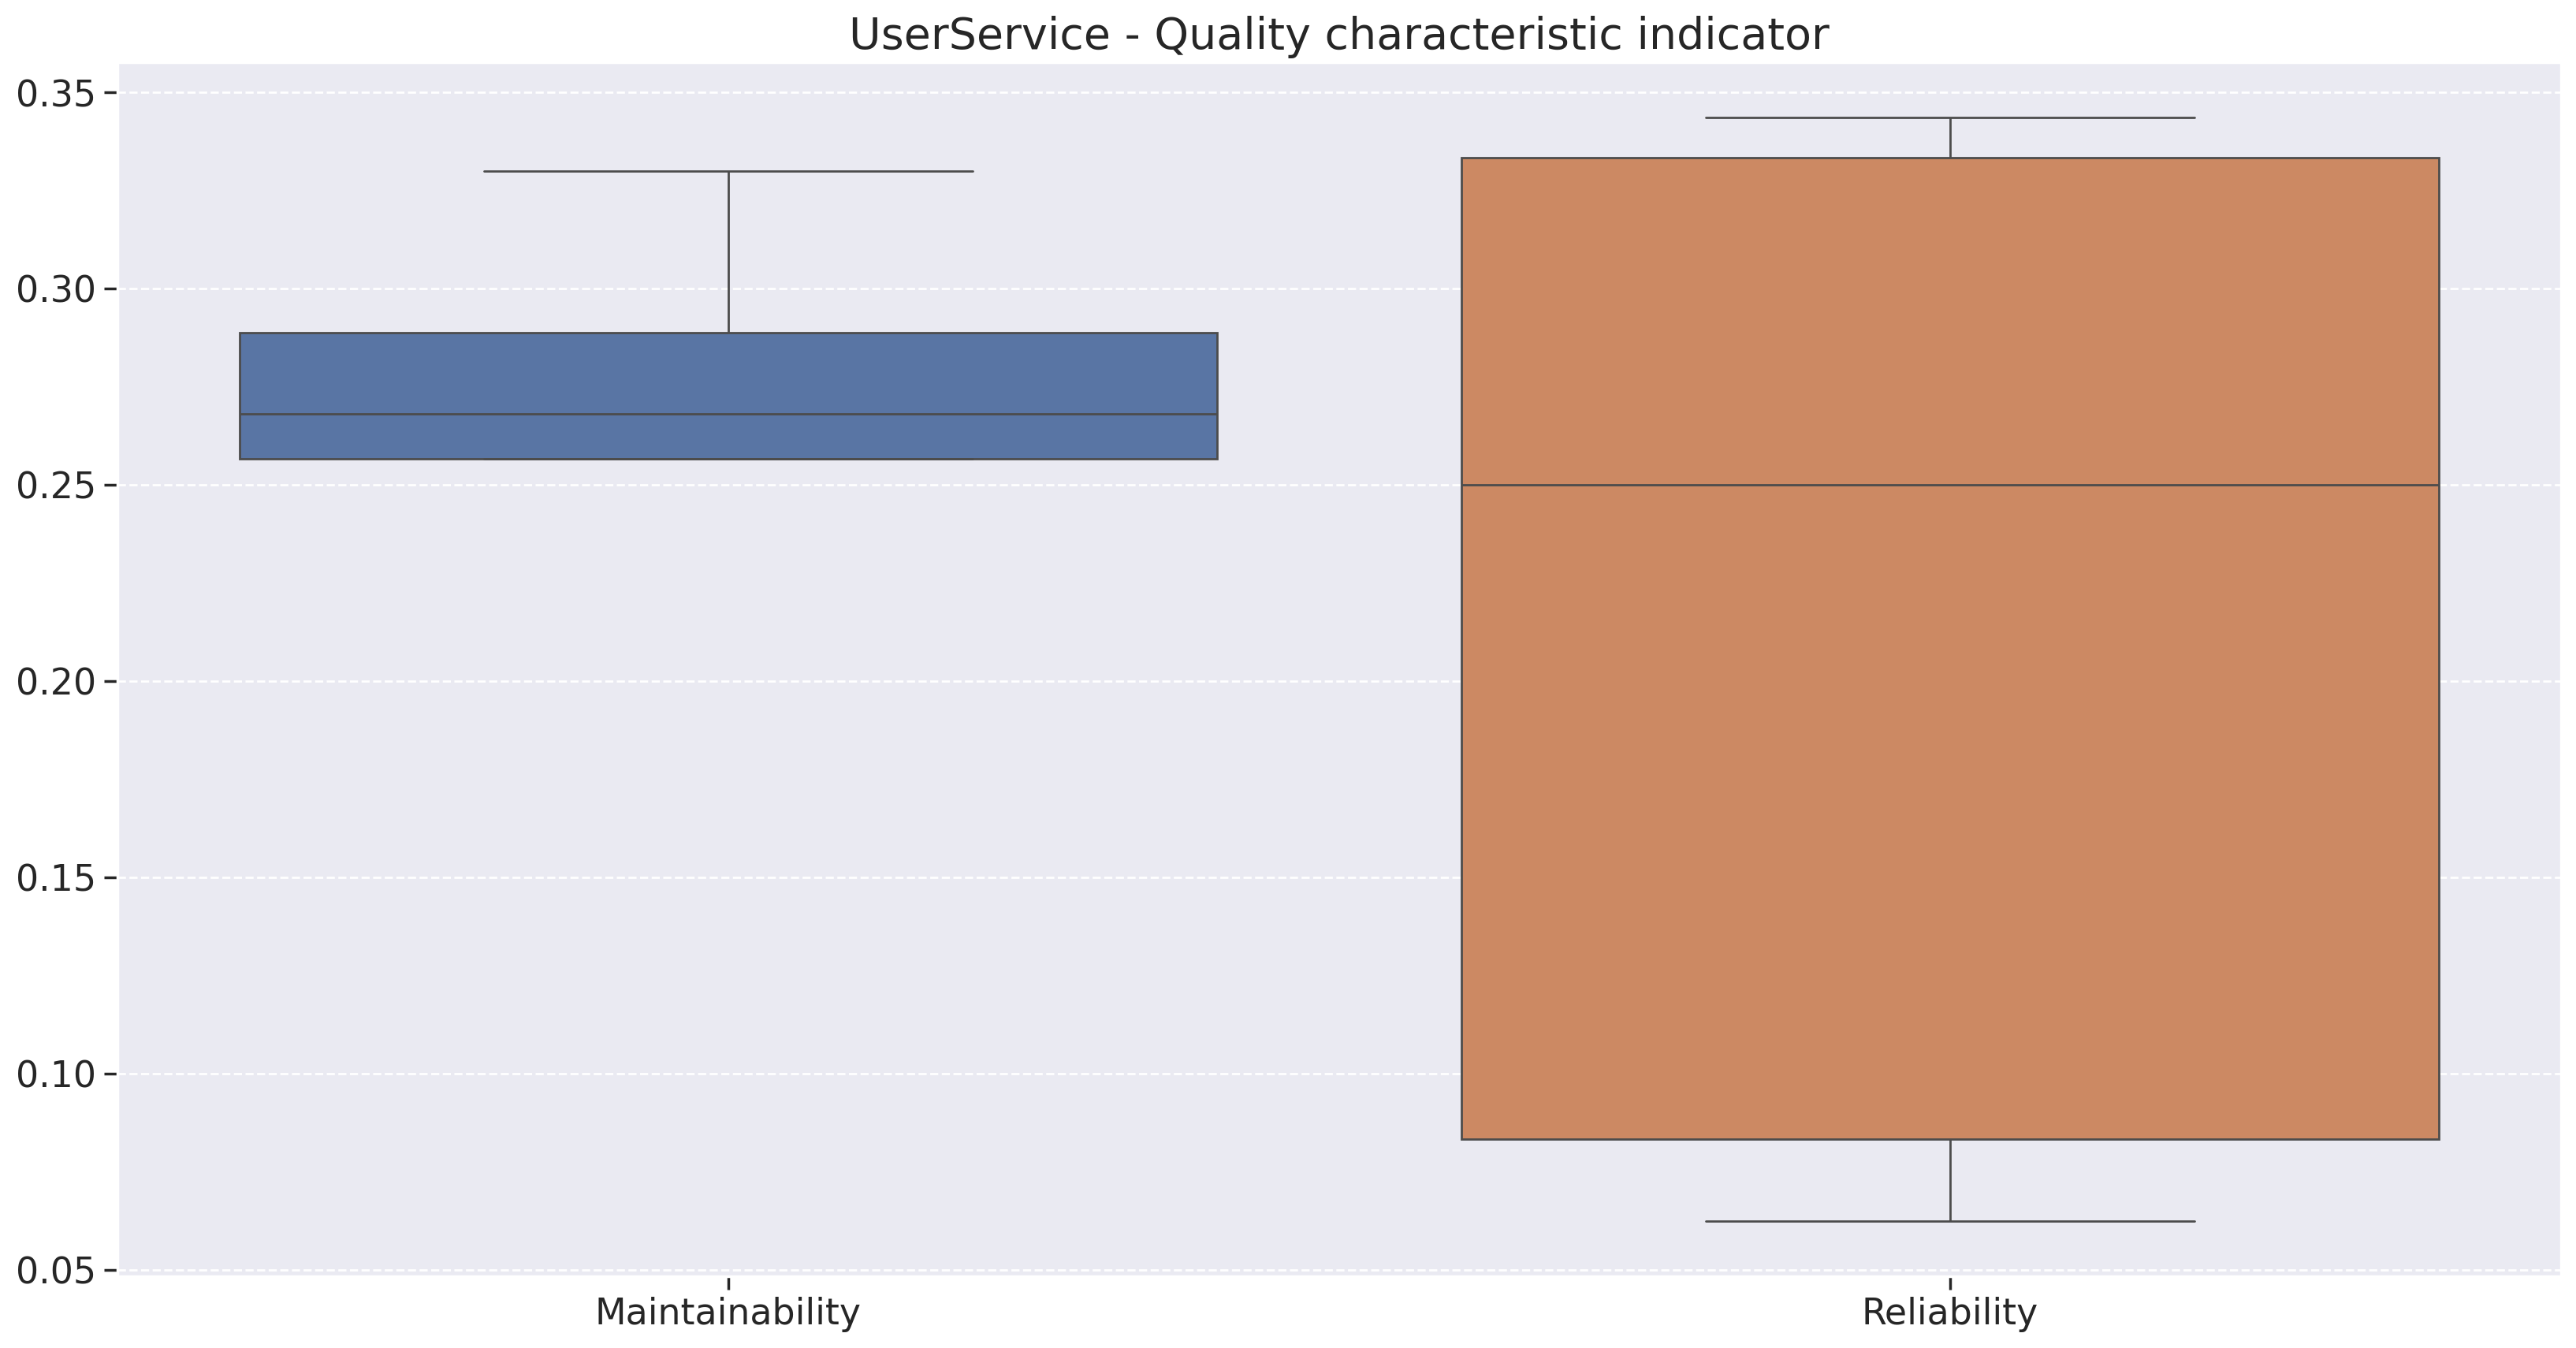

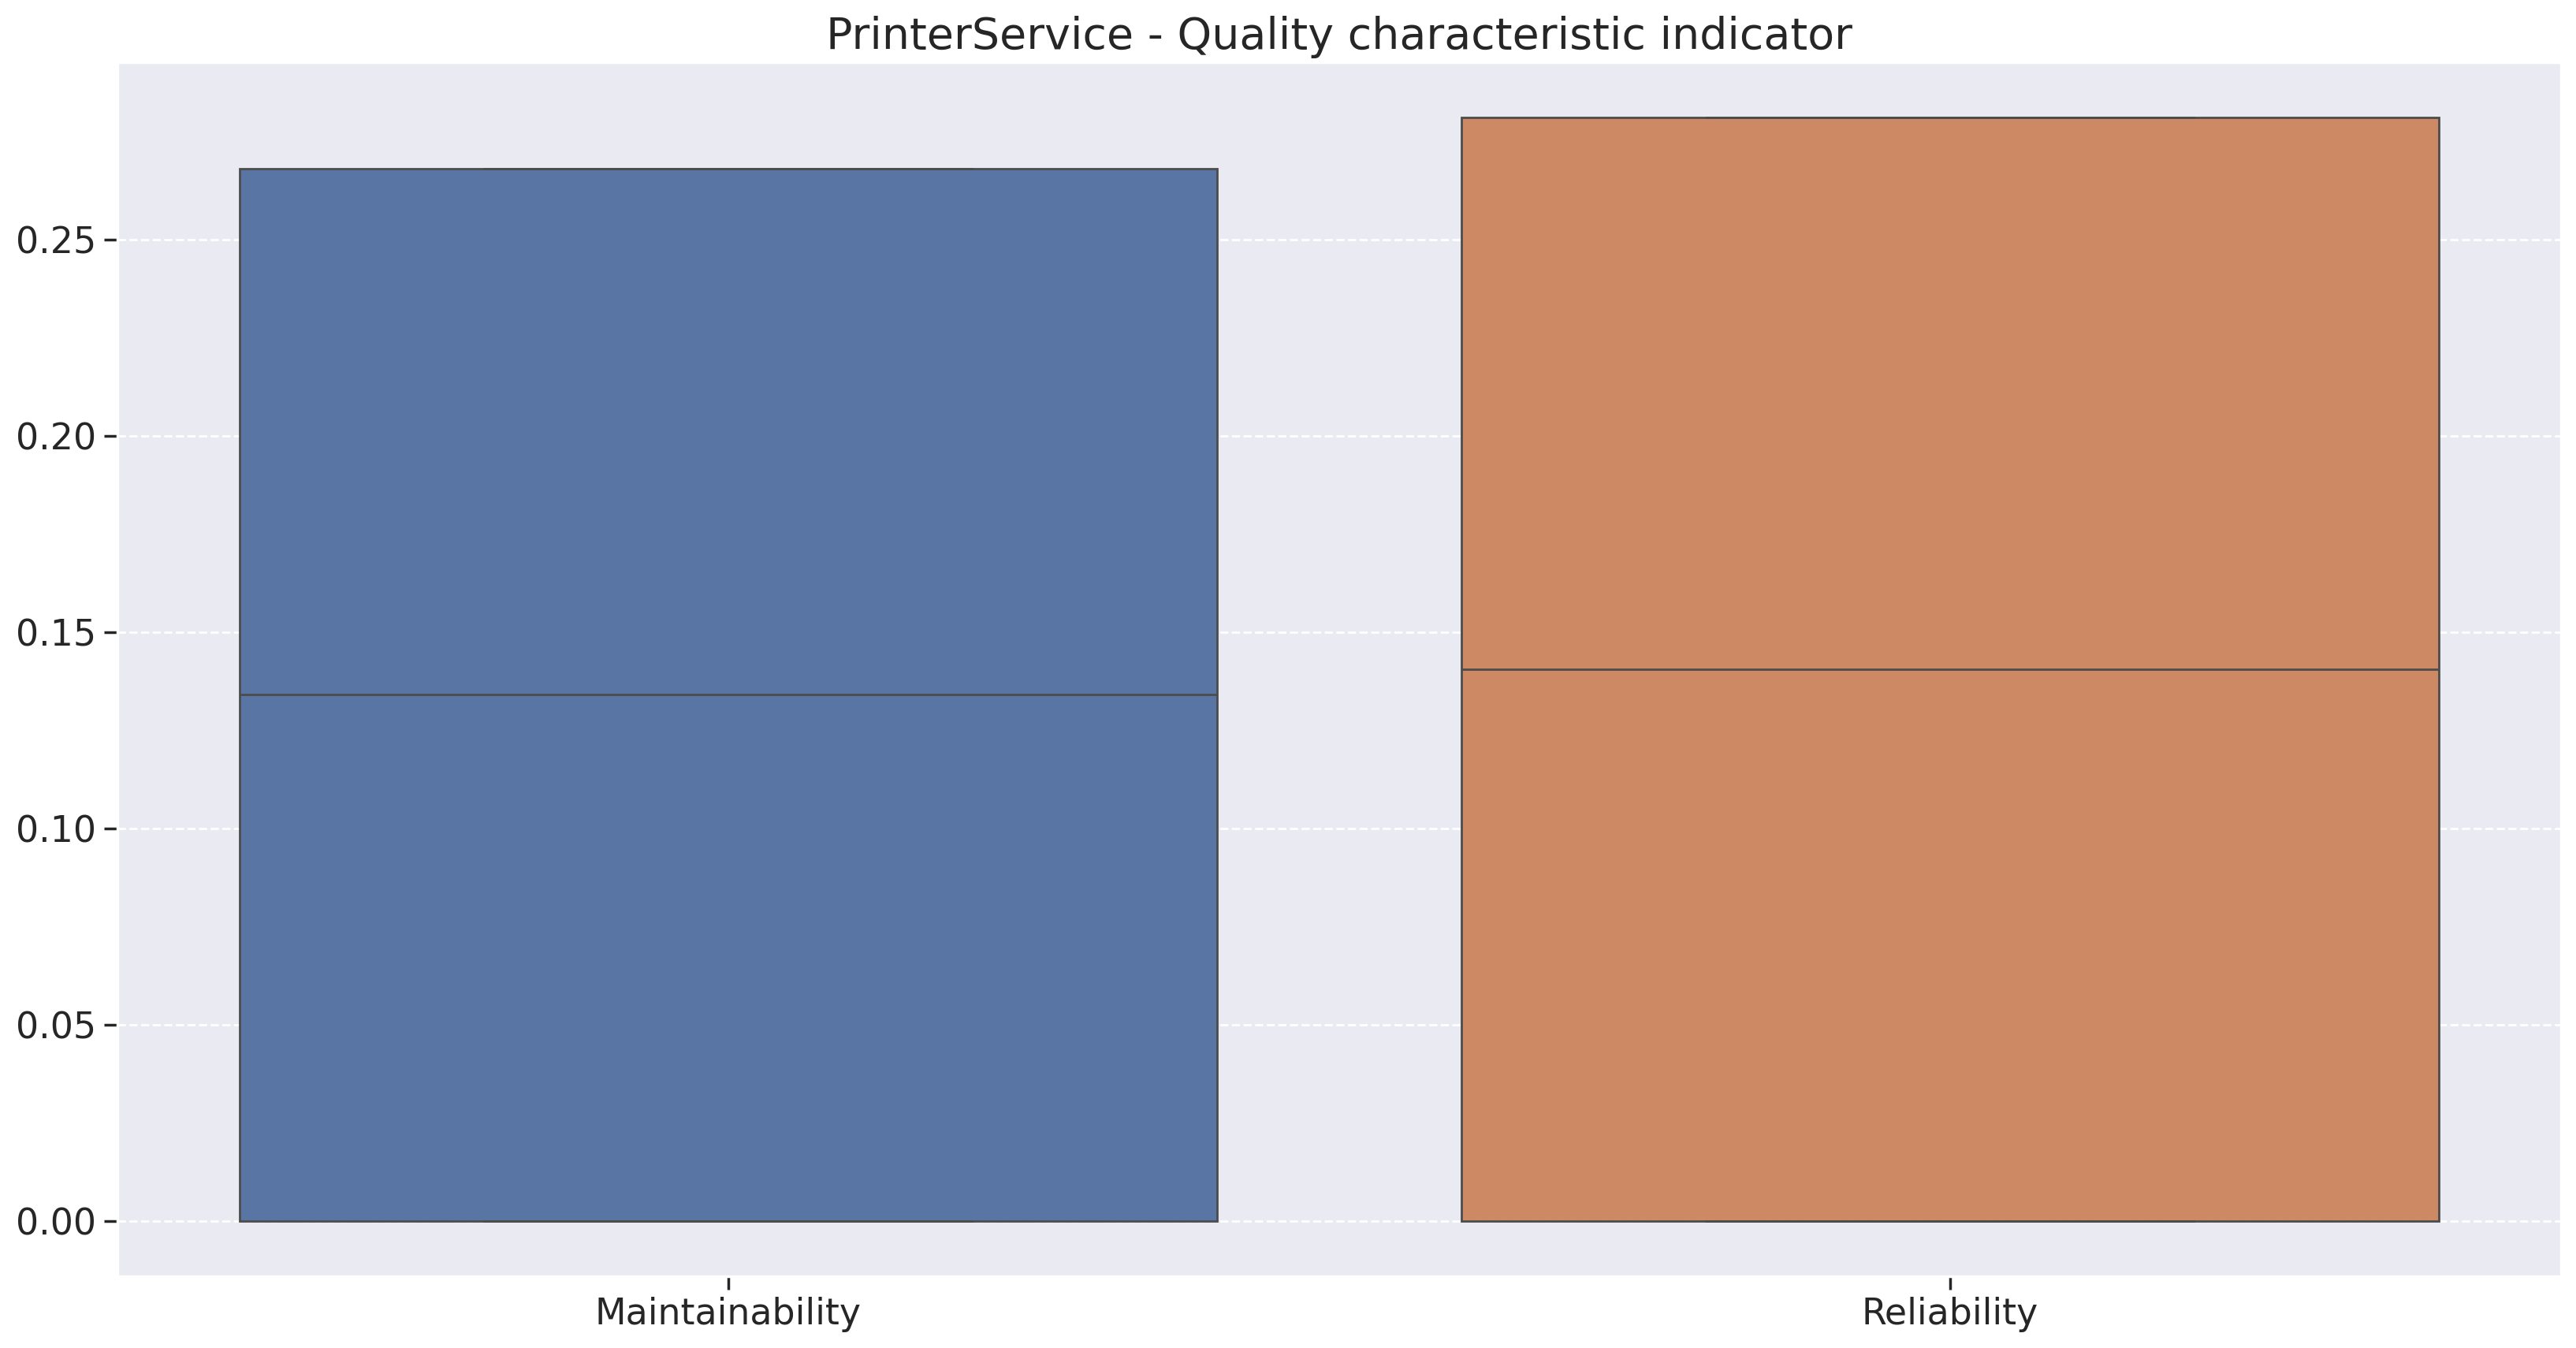

In [584]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

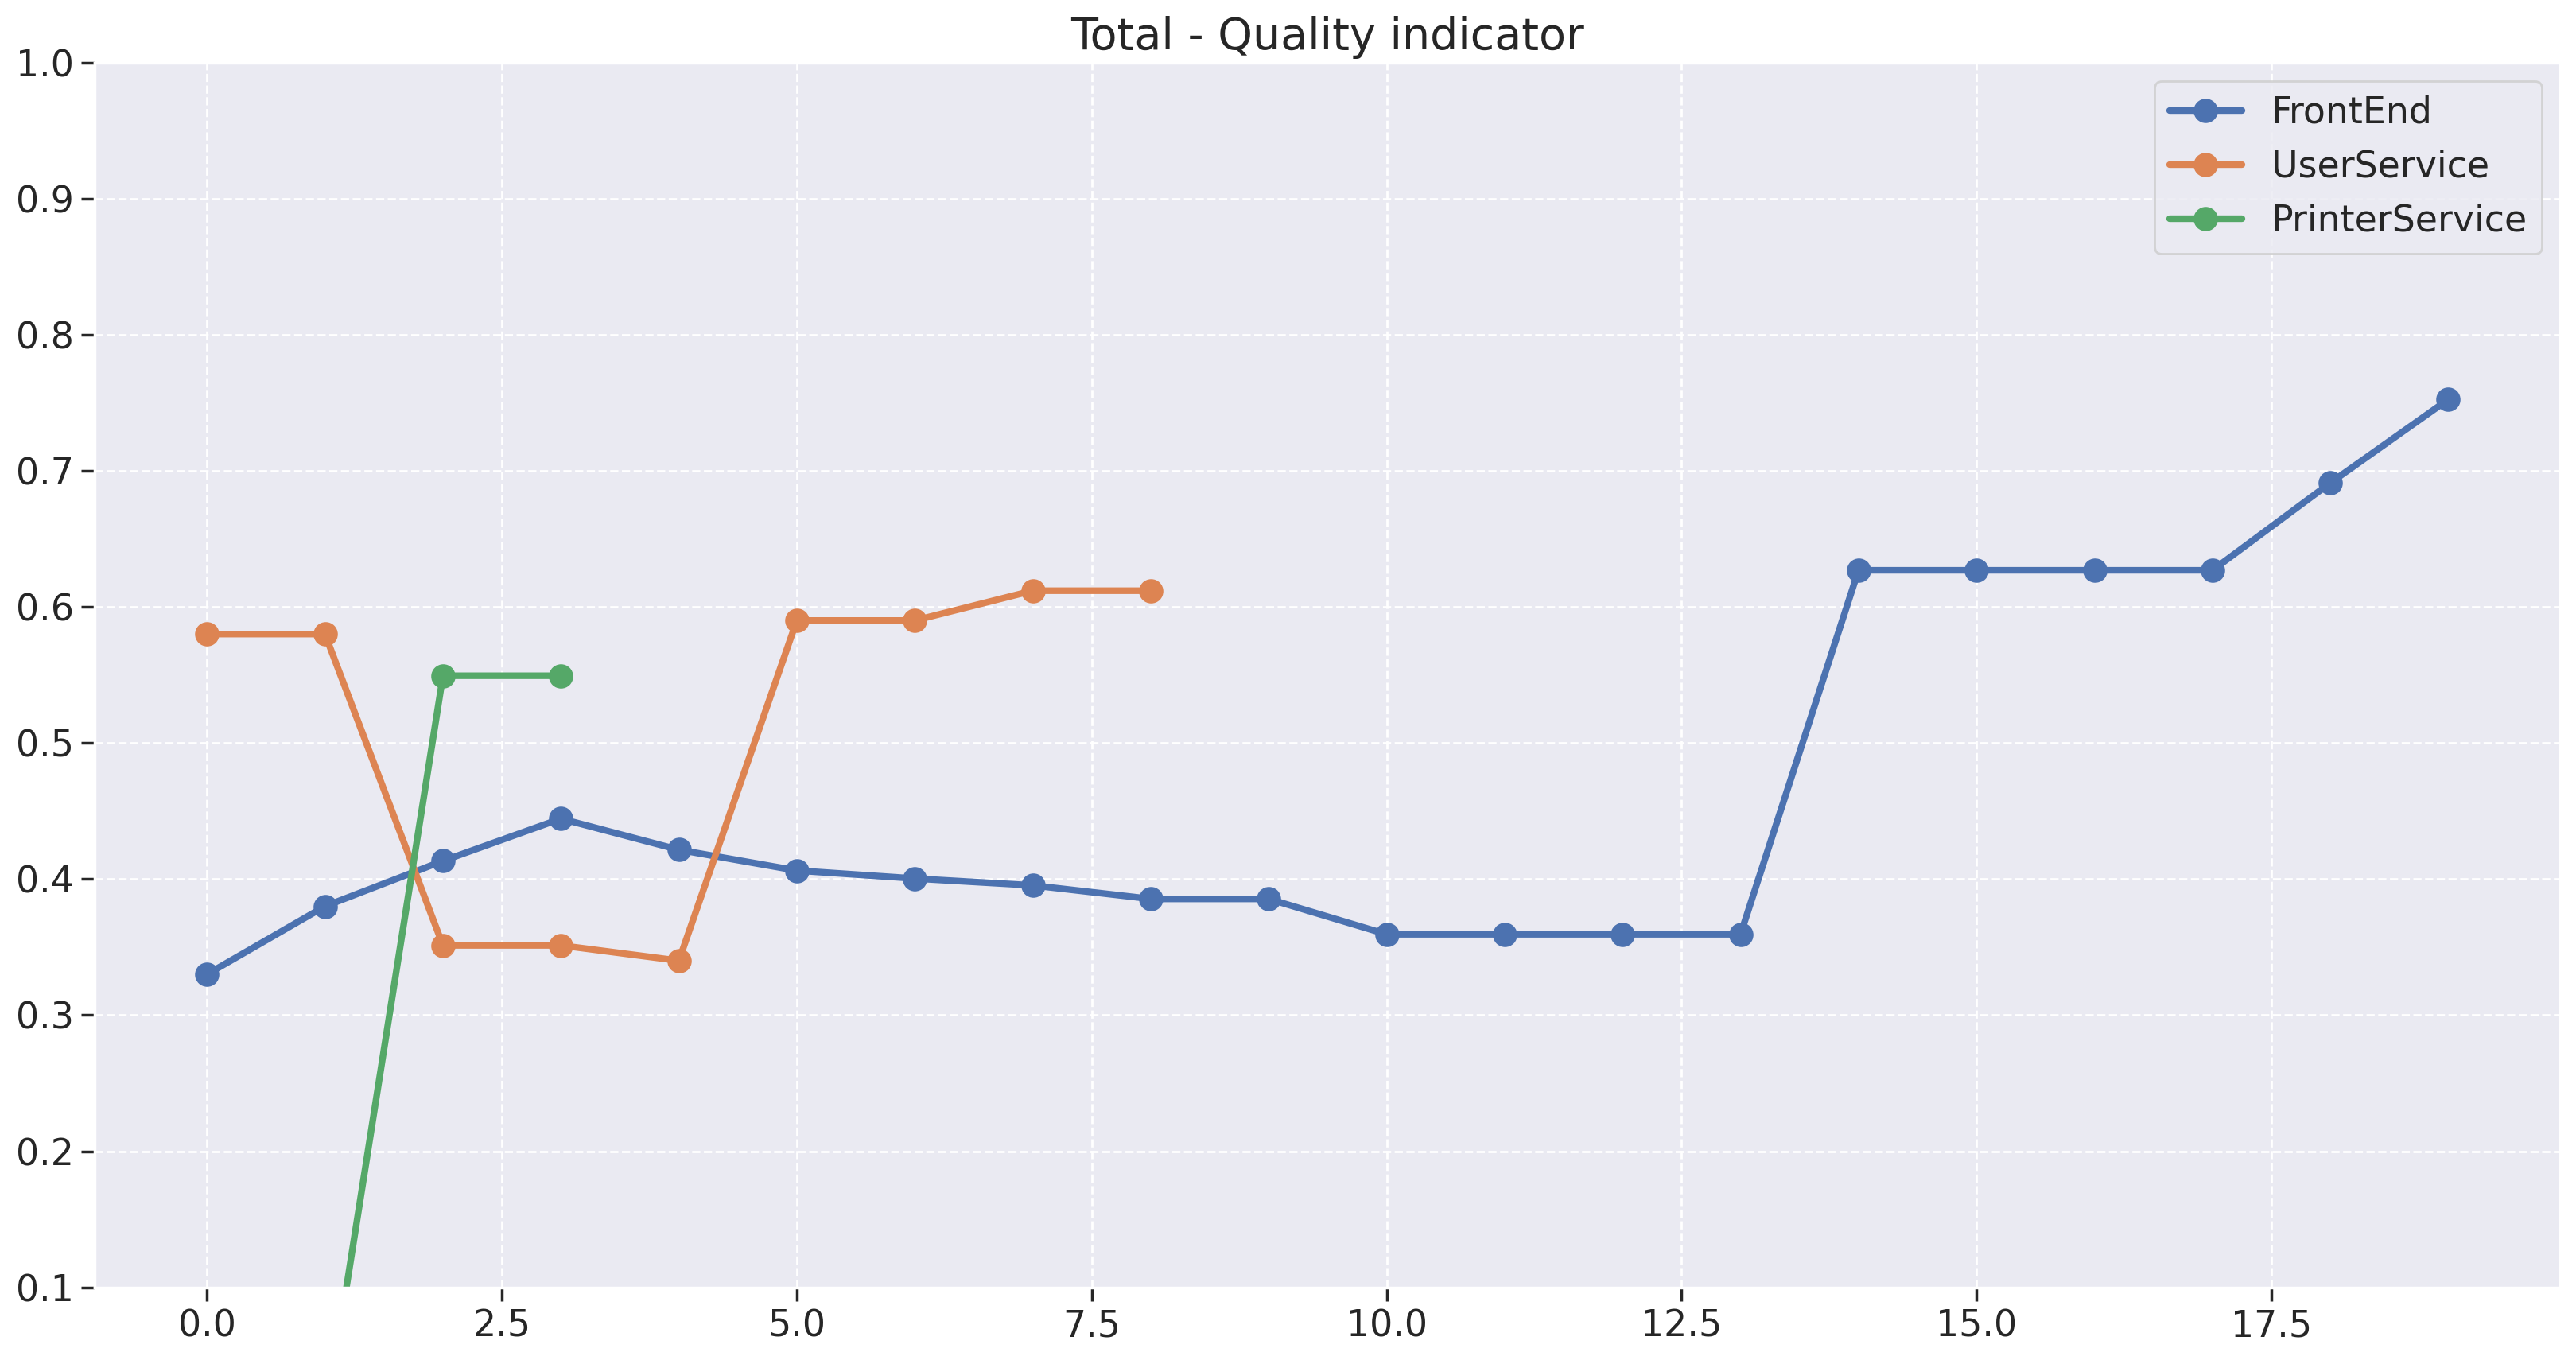

In [585]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [586]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('./data/fga-eps-mds-2022-2-MeasureSoftGram--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('./data/fga-eps-mds-2022-2-MeasureSoftGram--{}.csv'.format(current_datetime), index = False)

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.800000,0.200000,1.0,0.0,0.0,0.000000,fga-eps-mds-2023.2-PrintGo-FrontEnd,10-22-2023-03-05-33,168,0.660000,0.000000,0.330000,0.000000,0.330000
1,0.800000,0.200000,1.0,0.0,0.0,0.200000,fga-eps-mds-2023.2-PrintGo-FrontEnd,10-22-2023-15-16-32,168,0.660000,0.100000,0.330000,0.050000,0.380000
2,0.833333,0.166667,1.0,0.0,0.0,0.333333,fga-eps-mds-2023.2-PrintGo-FrontEnd,10-22-2023-21-28-59,621,0.660000,0.166667,0.330000,0.083333,0.413333
3,0.875000,0.250000,1.0,0.0,0.0,0.375000,fga-eps-mds-2023.2-PrintGo-FrontEnd,10-22-2023-23-43-11,1226,0.701250,0.187500,0.350625,0.093750,0.444375
4,0.900000,0.200000,1.0,0.0,0.0,0.300000,fga-eps-mds-2023.2-PrintGo-FrontEnd,10-23-2023-01-07-19,1900,0.693000,0.150000,0.346500,0.075000,0.421500
5,0.916667,0.166667,1.0,0.0,0.0,0.250000,fga-eps-mds-2023.2-PrintGo-FrontEnd,10-23-2023-01-23-50,2431,0.687500,0.125000,0.343750,0.062500,0.406250
6,0.923077,0.153846,1.0,0.0,0.0,0.230769,fga-eps-mds-2023.2-PrintGo-FrontEnd,10-23-2023-02-18-21,3024,0.685385,0.115385,0.342692,0.057692,0.400385
7,0.928571,0.142857,1.0,0.0,0.0,0.214286,fga-eps-mds-2023.2-PrintGo-FrontEnd,10-23-2023-02-48-36,3766,0.683571,0.107143,0.341786,0.053571,0.395357
8,0.916667,0.166667,1.0,0.0,0.0,0.166667,fga-eps-mds-2023.2-PrintGo-FrontEnd,10-25-2023-01-38-53,2708,0.687500,0.083333,0.343750,0.041667,0.385417
9,0.916667,0.166667,1.0,0.0,0.0,0.166667,fga-eps-mds-2023.2-PrintGo-FrontEnd,10-25-2023-16-27-22,2864,0.687500,0.083333,0.343750,0.041667,0.385417


ModuleNotFoundError: No module named 'openpyxl'